# Import all units
10/12/18

this noteobok is going to continue off of 07-Data_merging and will be extracting and annotating all of the units of each value and checking for distribution (to ensure all like values on same units). It serves as a primary exploration for how I want to import and standardize units, and assess extreme outliers (possible data errors) in each of hte clinical dataframes. The explored code here will be refined and implemented in 03.1-cinical_variable_prep.ipynb

- Goal: need to Finish extracting and annotating all unit values for each datatype for all of my clinical variables.
 - Will start over and put all scripts for this into 06.3-Unit_importing.ipynb.
 - EVENTUALLY NEED TO MERGE THIS INTO THE 03_CLINICAL_VARIABLE_Final



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
import numpy as np

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime
%reload_ext autotime

pd.options.mode.chained_assignment = None # turns off chained assignment warnings

In [2]:
#cohort import

os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'


final_pt_df2 = pd.read_csv(Path(wd + '/data/raw/csv/01102018_final_pt_df2_v.csv') , index_col=0) #only for patients with minimum vitals
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 103 ms


In [8]:
#adding this in fow now, will eventually want to switch this to the 03-clinical_variables_final
import psycopg2
import getpass
conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

Password: ·····


time: 2.4 s


In [83]:
# date= '27082018' 
# bg_all_nosummary_72=pd.read_csv(Path(
#     wd+'/data/raw/csv/72_hr_window/%s_bg_all_nosummary_72.csv' %(date)), index_col=0)


time: 1.55 s


In [4]:
#reading in all of my data that is not limited to 72 hour time window between t_0 and t+72
date= '27082018' 

ventcategory_df=pd.read_csv(Path(
    wd+'/data/raw/csv/%s_ventcategory_df.csv' %(date)), index_col=0)

vaso_dose_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_vaso_dose_72.csv' %(date)), index_col=0)


echodata_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_echodata_72.csv' %(date)), index_col=0)
labs_all_nosummary_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_labs_all_nosummary_72.csv' %(date)), index_col=0)


weightfirstday_df=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_weightfirstday_df.csv' %(date)), index_col=0)
heightfirstday_df=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_heightfirstday_df.csv' %(date)), index_col=0)

vitals_all_nosummary_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_vitals_all_nosummary_72.csv' %(date)), index_col=0)
uti_all_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_uti_all_72.csv' %(date)), index_col=0)
bg_all_nosummary_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_bg_all_nosummary_72.csv' %(date)), index_col=0)

rrt_merged_allpt_df=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_rrt_merged_allpt_df.csv' %(date)), index_col=0)
gcs72_df=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_gcs72_df.csv' %(date)), index_col=0)

sofa_df_72=pd.read_csv(Path(
    wd+'/data/raw/csv/%s_sofa_df_72.csv' %(date)), index_col=0)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 14.3 s


In [5]:
def df_subset(df):
    try:
        df = df.loc[df.loc[:,'icustay_id'].isin(icustay_id),:]
    except KeyError or NameError:
        try:
            df = df.loc[df.loc[:,'hadm_id'].isin(hadm_id),:]
        except KeyError or NameError:
            df = df.loc[df.loc[:,'subject_id'].isin(patients),:]
    return(df)

time: 6.2 ms


In [6]:
# subsetting each dataframe to only patients in final_patients_df2_v:
dataframe_list= [
    ventcategory_df, vaso_dose_72, echodata_72,
    labs_all_nosummary_72, weightfirstday_df,
    heightfirstday_df, vitals_all_nosummary_72,
    uti_all_72, bg_all_nosummary_72,
    rrt_merged_allpt_df, gcs72_df, sofa_df_72
]

(
ventcategory_df, vaso_dose_72, echodata_72,
labs_all_nosummary_72, weightfirstday_df,
heightfirstday_df, vitals_all_nosummary_72,
uti_all_72, bg_all_nosummary_72,
rrt_merged_allpt_df, gcs72_df, sofa_df_72
) = (df_subset(df) for df in dataframe_list)

time: 1.1 s


In [29]:
def extreme_value_vis(df, label_values=None,value='valuenum', Min=True, Max=True, std_num=3):  
    """
    takes in a dataframe and list of value_labels and will return a list of all values that 
    lie outside of +/- 3 sd range for these groups 
    """
    cond_1= df.loc[:,value].notna()
    
    if label_values == None:
        
        cond_2= df.loc[:,'label']
    else:
        cond_2= df.loc[:,'label'].isin(label_values)
        
    cond_3= df.loc[:,value]> df.loc[:,value].mean()+ df.loc[:,value].std()

    df_outlier_explore= df[cond_1& cond_2]
    df_outlier_explore['mean']=df_outlier_explore.groupby(['label'])[value].transform(lambda x : x.mean())
    df_outlier_explore['std']=df_outlier_explore.groupby(['label'])[value].transform(lambda x : x.std())

    df_outlier_explore['mean']=df_outlier_explore.groupby(['label'])[value].transform(lambda x : x.mean())

    if Max == True:
        cond4= (df_outlier_explore.loc[:,'value'].astype(float)>
                    (df_outlier_explore.loc[:,'mean'].astype(float)+std_num*df_outlier_explore.loc[:,'std'].astype(float)))
    else: cond4= False
    
    if Min == True:
        cond5= (df_outlier_explore.loc[:,'value'].astype(float)<
                    (df_outlier_explore.loc[:,'mean'].astype(float)-std_num*df_outlier_explore.loc[:,'std'].astype(float)))
    else: cond5= False
    return(df_outlier_explore.loc[cond4^cond5,:]) #rows that meet either condition but not both. 


time: 32.1 ms


In [7]:
#testing cv, mv, or both for each patient

cv_mv=pd.read_csv(Path(wd+'/data/raw/csv/12102018_ABrx_16sterile_ntnul_pts.csv'), index_col=0)

time: 34.6 ms


In [8]:
cv_mv.loc[cv_mv.loc[:,'subject_id'].isin(patients),'pt_ab_db'].value_counts() 

mv_ab              6090
cv_ab              5653
cv/mv_ab            619
both_marking_ab      41
Name: pt_ab_db, dtype: int64

time: 9.01 ms


10/5/18
# Standardizing Columns in df to merge together
### list of columns in master df:
- subject_id
- hadm_id
- icustay_id
- charttime: starttime/charttime.
- endtime: going to be null for any value listed with only a charttime. 
- label
- value
- units?
- t_0
- XdeltaX
- XdaysX
- XfrequencyX
- dtype

In [164]:
vaso_dose_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_vaso_dose_72.csv' %(date)), index_col=0)


time: 562 ms


### Vaso_dose

In [168]:
# #vaso_dose_72.head()
# vaso_dose_72= vaso_dose_72.rename(
#     columns={'starttime':'charttime','label':'vaso_type'}
#         )#.drop(labels='endtime', axis=1) 
# #renaming starttime to charttime and dropping endtime

# #vaso_dose_72['uom']= 'mg'

time: 31.6 ms


In [165]:
vaso_dose_72.head()

,icustay_id,starttime,endtime,vaso_rate,vaso_amount,amount_uom,rate_uom,label,t_0,delta
4,200349.0,2139-06-02 16:31:00,2139-06-02 18:10:00,0.012030,0.073958,mg,mcg/kg/min,epinephrine,2139-06-02,0 days 16:31:00.000000000
92,200952.0,2139-09-23 15:07:00,2139-09-24 06:43:00,0.020004,1.049601,mg,mcg/kg/min,epinephrine,2139-09-23,0 days 15:07:00.000000000
93,200952.0,2139-09-25 12:00:00,2139-09-25 21:59:00,0.080068,1.962759,mg,mcg/kg/min,epinephrine,2139-09-23,2 days 12:00:00.000000000
94,200952.0,2139-09-25 21:59:00,2139-09-26 07:38:00,0.060601,2.000000,mg,mcg/kg/min,epinephrine,2139-09-23,2 days 21:59:00.000000000
106,200952.0,2139-09-23 23:12:00,2139-09-24 21:54:00,0.149992,7.990853,mg,mcg/kg/min,norepinephrine,2139-09-23,0 days 23:12:00.000000000
107,200952.0,2139-09-24 21:54:00,2139-09-25 13:17:00,0.201337,7.325205,mg,mcg/kg/min,norepinephrine,2139-09-23,1 days 21:54:00.000000000
108,200952.0,2139-09-25 13:17:00,2139-09-26 03:45:00,0.351255,7.958630,mg,mcg/kg/min,norepinephrine,2139-09-23,2 days 13:17:00.000000000
118,200952.0,2139-09-25 09:24:00,2139-09-26 21:27:00,4.800000,99.999663,units,units/hour,vasopressin,2139-09-23,2 days 09:24:00.000000000
122,200952.0,2139-09-23 15:06:00,2139-09-24 00:51:00,2.509001,43.660095,mg,mcg/kg/min,phenylephrine,2139-09-23,0 days 15:06:00.000000000
124,201005.0,2169-10-25 17:25:00,2169-10-25 18:00:00,0.020000,NaN,NaN,mcgkgmin,epinephrine,2169-10-25,0 days 17:25:00.000000000


time: 47.2 ms


When looking at only the units of measurement in all inputevents_cv/mv:
### DOPAMINE : 
- Cv: Mg
 - (30043,30307)Mgkgmin
- Mv: Mg
 - mcg/kg/min
 
### Epinephrine: 
- Cv: mg
 - 30044, Mcgmin
 - 30119,30309  Mcgkgmin
- Mv: mg, mcg
 - 221289: mcg/kg/min
 
### Norepinephrine:  
- Cv: mg
 - 30047: mcgmin 
 - 30120: mcgkgmin
- Mv: mg, mcg
 - 221906: mcg/kg/min
 
### Dobutamine:
- cv:mg
 - Mcgkgmin
- Mv:mg
 - 221653: mcg/kg/min
 
### Vasopressin: 
- Cv: ml, U
 - Umin
 - Uhr
- MV: units
 - units/min
 - units/hr
 
### Phenylephrine: 
- Cv: mg
 - 30127: mcgmin
 - 30128: mcgkgmin
- Mv: mg
 - 221749: mcg/kg/min


units and itemid's ssummarized above, waiting on nelsons's feedback for how to proceed. 
##### questions:
- is mcg/min a shorthand for mcg/kg/min? or are these fundamentally different? 
 - answer: yes but mimic did account for this in the sql code.
- should i be worried that the amount uom is listed in mg, but the rate is in mcg (which appears to be shorthand for micrograms). 
    - answer: no, mimic accounted for this

### update from nelson:
I think the units mean what they mean, I don’t think there are any shorthands. We can double check. For example, most of the doses of Epinephrine and Norepinephrine in mcg/kg/min should fall in the range 0.05 to 0.1 (for dobutamine and dopamine more like 5 to 20). If the mcg/min value is truly that, then the range will depend on the patients weight. Say a 60kg patients range in mcg/min will be 3 to 6. Question: For each of these are the rates recorded in both units or some are mcg/kg/min and others mcg/min?

Also, for vasopressin: don’t use the units/HOUR ones. Those are doses that are NOT used for vasoactive purposes, so we should not be mixing it with this group of meds. Think of it as a completely different medication. 

### update on 12/15/18:
i've adjusted the sql code for each vaso_active medication to additionally extract the amount_uom and rate_uom. this is updated in the 03-clinical_variables_final.ipynb.

In [169]:
vaso_dose_72.head()

,icustay_id,charttime,endtime,vaso_rate,vaso_amount,amount_uom,rate_uom,vaso_type,t_0,delta
4,200349.0,2139-06-02 16:31:00,2139-06-02 18:10:00,0.012030,0.073958,mg,mcg/kg/min,epinephrine,2139-06-02,0 days 16:31:00.000000000
92,200952.0,2139-09-23 15:07:00,2139-09-24 06:43:00,0.020004,1.049601,mg,mcg/kg/min,epinephrine,2139-09-23,0 days 15:07:00.000000000
93,200952.0,2139-09-25 12:00:00,2139-09-25 21:59:00,0.080068,1.962759,mg,mcg/kg/min,epinephrine,2139-09-23,2 days 12:00:00.000000000
94,200952.0,2139-09-25 21:59:00,2139-09-26 07:38:00,0.060601,2.000000,mg,mcg/kg/min,epinephrine,2139-09-23,2 days 21:59:00.000000000
106,200952.0,2139-09-23 23:12:00,2139-09-24 21:54:00,0.149992,7.990853,mg,mcg/kg/min,norepinephrine,2139-09-23,0 days 23:12:00.000000000


time: 12.4 ms


In [170]:
vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_amount'].isna(),'vaso_type'].value_counts()/ vaso_dose_72.loc[:,'vaso_type'].value_counts()
#it looks like the vaso_amounts missingness is roughly porportional to the total number. 
#ie not a large bias towards some vasodilators having more missing vaso_amount
#this looks like it could be a case for using just vaso_rate.

#also from the SQL documentation: vaso_amount for carevue is not accurate. 

norepinephrine    0.803403
phenylephrine     0.777018
dopamine          0.873960
vasopressin       0.872309
epinephrine       0.833494
dobutamine        0.883736
Name: vaso_type, dtype: float64

time: 55.3 ms


In [ ]:
#task 1: lets look at the vaso_rate distributions. 

In [36]:
vaso_dose_72.groupby('vaso_type')['vaso_rate'].describe()

##vasoactive medication, not necessarily vasodilator.  normal ranges:
#dop: 0-40 ug/kg/min
#dobu: 0-40 ug/kg/min
#epi: 0-~5 ug/kg/min
#nor:0-~5 ug/kg/min
#phenyl: 0-~10 ug/kg/min
#vaso: 0-~10 units/kg/min (can be used for other types of patients w/ diabetes insipidus)


,count,mean,std,min,25%,50%,75%,max
vaso_type,,,,,,,,
dobutamine,947.0,5.125060,4.055376,0.249004,2.500000,4.000000,6.300000,25.000000
dopamine,5093.0,7.355780,9.209863,0.244873,3.333333,5.250000,10.000000,523.784242
epinephrine,1179.0,0.092613,0.573252,0.002000,0.020000,0.036613,0.085357,19.244444
norepinephrine,24115.0,0.173934,0.609784,0.000113,0.050000,0.100000,0.203860,61.439027
phenylephrine,16578.0,1.650212,4.261559,0.010000,0.500000,1.000000,2.000000,420.168221
vasopressin,1810.0,1.806855,10.219186,0.000267,0.040000,2.000000,2.400000,428.571426


time: 80.3 ms


each of the vaso_dilators have a very large maximum value 
that is many standard deviations above the mean. I need to investigate this

In [53]:
#finding the outlier
dopa_outlier1= vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_rate']==523.7842421053,:] 
dopa_outlier1

,icustay_id,starttime,endtime,vaso_rate,vaso_amount,label,t_0,delta
69993,274503.0,2181-12-14 16:12:00,2181-12-14 22:02:00,523.784242,400.000315,dopamine,2181-12-13,1 days 16:12:00.000000000


time: 12 ms


In [46]:
#looking at all values from the outlier
vaso_dose_72.loc[vaso_dose_72.loc[:,'icustay_id']==274503.0,:] 

,icustay_id,charttime,vaso_rate,vaso_amount,vaso_type,t_0,delta
69986,274503.0,2181-12-14 16:12:00,0.986466,7.999642,norepinephrine,2181-12-13,1 days 16:12:00.000000000
69987,274503.0,2181-12-14 22:21:00,0.493142,1.827091,norepinephrine,2181-12-13,1 days 22:21:00.000000000
69989,274503.0,2181-12-13 10:02:00,9.967099,400.000027,dopamine,2181-12-13,0 days 10:02:00.000000000
69990,274503.0,2181-12-13 17:18:00,9.966993,393.120509,dopamine,2181-12-13,0 days 17:18:00.000000000
69991,274503.0,2181-12-14 01:50:00,7.980863,400.320080,dopamine,2181-12-13,1 days 01:50:00.000000000
69992,274503.0,2181-12-14 10:38:00,11.961724,161.451978,dopamine,2181-12-13,1 days 10:38:00.000000000
69993,274503.0,2181-12-14 16:12:00,523.784242,400.000315,dopamine,2181-12-13,1 days 16:12:00.000000000
69994,274503.0,2181-12-14 22:02:00,20.210527,88.320005,dopamine,2181-12-13,1 days 22:02:00.000000000
69995,274503.0,2181-12-14 22:48:00,20.208422,23.037601,dopamine,2181-12-13,1 days 22:48:00.000000000
69996,274503.0,2181-12-14 22:47:00,3.007519,3.714286,phenylephrine,2181-12-13,1 days 22:47:00.000000000


time: 13.8 ms


In [48]:
final_pt_df2.loc[final_pt_df2.loc[:,'icustay_id']==274503.0,:] 
#patient is a C_pos/A_full, makes sense why they may have had a high rate of vaso_rate

,subject_id,icustay_id,hadm_id,t_0_sc,t_end_sc,ab_course,t_0,t_end_consec,ICU_admit,dod_hosp,dod_ssn,dod_delta,org_list,spec_type_list,sc_result,final_bin
3692,49613,274503.0,120323,2181-12-12 00:00:00,2181-12-15 00:00:00,full,2181-12-13,2181-12-15,2181-12-12 18:40:21,NaN,NaN,NaN,GRAM POSITIVE BACTERIA,URINE,positive,C_pos/A_full


time: 16.5 ms


[Text(0,0,'epinephrine'),
 Text(0,0,'norepinephrine'),
 Text(0,0,'vasopressin'),
 Text(0,0,'phenylephrine'),
 Text(0,0,'dopamine'),
 Text(0,0,'dobutamine')]

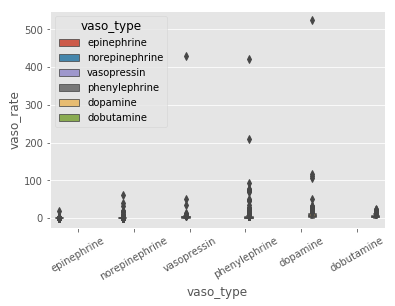

time: 349 ms


In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
g= sns.boxplot(x="vaso_type", y="vaso_rate", hue="vaso_type", data=vaso_dose_72)
g.set_xticklabels(g.get_xticklabels(), rotation=30)


## UOM data distribution 12/15/18:
the uom was recently added (after the above distribution analysis) to the sql code and now I wanan see the distribution of variables between the different uom's  and if difference between cv vs mv.

In [172]:
vaso_dose_72.groupby('vaso_type')['rate_uom'].value_counts()

vaso_type       rate_uom  
dobutamine      mcgkgmin       1391
                mcg/kg/min      183
dopamine        mcgkgmin       5041
                mcg/kg/min      727
epinephrine     mcgkgmin       1732
                mcg/kg/min      346
norepinephrine  mcgkgmin      19125
                mcg/kg/min     4680
phenylephrine   mcgkgmin      12388
                mcg/kg/min     3555
vasopressin     Umin           3924
                units/hour      605
                Uhr             209
Name: rate_uom, dtype: int64

time: 13.3 ms


In [ ]:
#removing units/hour because that is a different use of vasopressin
vaso_dose_72 = vaso_dose_72.loc[vaso_dose_72.loc[:,'rate_uom']!= 'units/hour',:]
vaso_dose_72 = vaso_dose_72.loc[vaso_dose_72.loc[:,'rate_uom']!= 'Uhr',:]

according to nelson: Most of the doses of Epinephrine and Norepinephrine in mcg/kg/min should fall in the range 0.05 to 0.1 
(for dobutamine and dopamine more like 5 to 20). If the mcg/min value is truly that, then the range will depend on the patients weight. 
Say a 60kg patients range in mcg/min will be 3 to 6. 



In [195]:
#epinephrine
##grouping by the different uom's (mcg/kg/min = mv, mcgkgmin = cv)
(vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_type']=='epinephrine',['vaso_amount','vaso_rate','rate_uom','amount_uom']]
     .groupby('rate_uom')
         .describe(percentiles=[.25, .5, .75,.95, .99])
             .T)


rate_uom           mcg/kg/min     mcgkgmin
vaso_amount count  346.000000     0.000000
            mean     2.283686          NaN
            std      2.279502          NaN
            min      0.007578          NaN
            25%      0.964909          NaN
            50%      1.938800          NaN
            75%      2.000000          NaN
            95%      7.999674          NaN
            99%      8.000098          NaN
            max     10.227201          NaN
vaso_rate   count  346.000000  1732.000000
            mean     0.161633     0.055967
            std      1.040042     0.110696
            min      0.009934     0.004000
            25%      0.030021     0.020000
            50%      0.060428     0.030000
            75%      0.137081     0.050000
            95%      0.342195     0.150000
            99%      0.570306     0.700000
            max     19.244444     1.000325

time: 36.3 ms


In [229]:
outlier_col= ['icustay_id','charttime','vaso_rate','rate_uom','t_0']

time: 4.2 ms


In [308]:
#trying to use double groupby to look at most extreme values

vaso_desc_df= (vaso_dose_72[['vaso_rate','rate_uom','amount_uom','vaso_type']]#.groupby('vaso_type', as_index=False)
     .groupby(['vaso_type','rate_uom'])
         .describe(percentiles=[.25, .5, .75,.95, .99]).T
              )
vaso_desc_df

vaso_type        dobutamine                 dopamine              epinephrine  \
rate_uom         mcg/kg/min     mcgkgmin  mcg/kg/min     mcgkgmin  mcg/kg/min   
vaso_rate count  183.000000  1391.000000  727.000000  5041.000000  346.000000   
          mean     7.139323     5.283263   12.378964     6.609771    0.161633   
          std      4.735680     4.090844   20.927020     4.749434    1.040042   
          min      0.500095     0.249004    1.000050     0.300000    0.009934   
          25%      3.997290     2.500000    6.006746     3.000000    0.030021   
          50%      5.031275     4.317789   10.016277     5.000000    0.060428   
          75%      9.991090     7.233797   15.922077     9.000000    0.137081   
          95%     18.012515    12.500000   20.255019    17.777777    0.342195   
          99%     20.407158    20.000000   24.743113    20.000000    0.570306   
          max     21.132713    25.000000  523.784242    50.000000   19.244444   

vaso_type                    norepinephrine               phenylephrine  \
rate_uom            mcgkgmin     mcg/kg/min      mcgkgmin    mcg/kg/min   
vaso_rate count  1732.000000    4680.000000  19125.000000   3555.000000   
          mean      0.055967       0.313418      0.156016      2.718101   
          std       0.110696       1.268170      0.253149      8.701782   
          min       0.004000       0.005000      0.000113      0.050001   
          25%       0.020000       0.100073      0.050000      1.000000   
          50%       0.030000       0.220097      0.100000      1.999802   
          75%       0.050000       0.386390      0.200000      3.527473   
          95%       0.150000       0.514732      0.450000      5.094801   
          99%       0.700000       1.336456      0.800000      9.574974   
          max       1.000325      61.439027     18.000000    420.168221   

vaso_type                     vasopressin                           
rate_uom             mcgkgmin         Uhr         Umin  units/hour  
vaso_rate count  12388.000000  209.000000  3924.000000  605.000000  
          mean       1.495109    2.555694     1.264520    3.293945  
          std        1.561586    0.897371     1.718483   17.391786  
          min        0.010000    0.400000     0.000267    0.040000  
          25%        0.500000    2.400000     0.040000    2.400000  
          50%        1.000000    2.400000     1.200000    2.400000  
          75%        2.000000    2.400000     2.400000    2.402884  
          95%        4.300000    4.800000     2.486500    3.605443  
          99%        7.000000    4.800000     4.800000    6.426894  
          max       50.000000    4.800000    50.000000  428.571426

time: 93.4 ms


In [306]:
(vaso_dose_72.loc[(vaso_dose_72.loc[:,'rate_uom']=='mcg/kg/min') ,['icustay_id','vaso_type','charttime','vaso_rate','rate_uom','t_0']]
     .groupby('vaso_type', as_index=False).head().sort_values('vaso_rate',ascending=False)
         )

,icustay_id,vaso_type,charttime,vaso_rate,rate_uom,t_0
347,201906.0,dopamine,2178-12-26 08:39:00,24.822132,mcg/kg/min,2178-12-26
348,201906.0,dopamine,2178-12-27 01:57:00,20.490754,mcg/kg/min,2178-12-26
349,201906.0,dopamine,2178-12-27 05:58:00,20.259796,mcg/kg/min,2178-12-26
350,201906.0,dopamine,2178-12-27 09:48:00,20.259000,mcg/kg/min,2178-12-26
2226,213945.0,dopamine,2167-02-14 23:00:00,20.073067,mcg/kg/min,2167-02-14
1964,211347.0,dobutamine,2135-09-28 23:20:00,10.007198,mcg/kg/min,2135-09-27
1966,211347.0,dobutamine,2135-09-29 12:43:00,10.006805,mcg/kg/min,2135-09-27
1965,211347.0,dobutamine,2135-09-29 06:25:00,10.006328,mcg/kg/min,2135-09-27
2623,217082.0,dobutamine,2121-06-13 20:10:00,5.007712,mcg/kg/min,2121-06-11
354,201906.0,phenylephrine,2178-12-27 01:03:00,4.873294,mcg/kg/min,2178-12-26


time: 22.7 ms


In [271]:
cv_vaso_outlier_df= (vaso_dose_72.loc[(vaso_dose_72.loc[:,'rate_uom']=='mcg/kg/min') ,
                  ['icustay_id','vaso_type','charttime','vaso_rate','rate_uom','t_0']] #columns to include in output
 .sort_values('vaso_rate', ascending=False)
     .groupby('vaso_type', as_index=False)
         .head()
             ).sort_values(['vaso_type','vaso_rate'], ascending=False)

time: 13.1 ms


In [278]:
cv_vaso_outlier_df['db_group']= 'cv'

time: 971 µs


In [270]:
mv_vaso_outlier_df=(vaso_dose_72.loc[(vaso_dose_72.loc[:,'rate_uom']=='mcgkgmin') ,
                  ['icustay_id','vaso_type','charttime','vaso_rate','rate_uom','t_0']] #columns to include in output
 .sort_values('vaso_rate', ascending=False)
     .groupby('vaso_type', as_index=False)
         .head()
             ).sort_values(['vaso_type','vaso_rate'], ascending=False)

time: 20.2 ms


In [277]:
mv_vaso_outlier_df['db_group']= 'mv'

time: 1.49 ms


In [280]:
vaso_outlier_df= pd.concat([cv_vaso_outlier_df,mv_vaso_outlier_df], join="outer")

time: 8.89 ms


In [309]:
date= '15102018'

pd.DataFrame(vaso_outlier_df).to_csv(Path(
    '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/interim/%s_vaso_outlier_df.csv' %(date)))
pd.DataFrame(vaso_desc_df).to_csv(Path(
    '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/interim/%s_vaso_desc_df.csv' %(date)))

#/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/interim

time: 7.57 ms


In [272]:
cv_vaso_outlier_df

,icustay_id,vaso_type,charttime,vaso_rate,rate_uom,t_0
84067,282529.0,phenylephrine,2198-12-30 14:22:00,420.168221,mcg/kg/min,2198-12-28
49228,239660.0,phenylephrine,2132-10-10 18:45:00,208.623115,mcg/kg/min,2132-10-10
38567,225600.0,phenylephrine,2186-07-02 13:30:00,94.113639,mcg/kg/min,2186-07-02
83594,281790.0,phenylephrine,2104-09-18 03:40:00,78.186513,mcg/kg/min,2104-09-16
81245,278838.0,phenylephrine,2174-11-29 14:45:00,76.883056,mcg/kg/min,2174-11-29
82278,280102.0,norepinephrine,2199-09-01 02:49:00,61.439027,mcg/kg/min,2199-09-01
55916,248622.0,norepinephrine,2193-05-04 00:45:00,38.748539,mcg/kg/min,2193-05-04
55917,248622.0,norepinephrine,2193-05-04 04:21:00,31.189081,mcg/kg/min,2193-05-04
55919,248622.0,norepinephrine,2193-05-04 04:27:00,19.376501,mcg/kg/min,2193-05-04
55918,248622.0,norepinephrine,2193-05-04 04:24:00,19.374658,mcg/kg/min,2193-05-04


time: 14.6 ms


In [299]:
vaso_dose_72[['vaso_rate','rate_uom','amount_uom']]

,vaso_rate,rate_uom,amount_uom
4,0.012030,mcg/kg/min,mg
92,0.020004,mcg/kg/min,mg
93,0.080068,mcg/kg/min,mg
94,0.060601,mcg/kg/min,mg
106,0.149992,mcg/kg/min,mg
107,0.201337,mcg/kg/min,mg
108,0.351255,mcg/kg/min,mg
118,4.800000,units/hour,units
122,2.509001,mcg/kg/min,mg
124,0.020000,mcgkgmin,NaN


time: 17.1 ms


In [315]:
#trying to use double groupby to repeat previous exploration more simply

(vaso_dose_72[['vaso_rate','rate_uom','amount_uom','vaso_type']]#.groupby('vaso_type', as_index=False)
     .groupby(['vaso_type','rate_uom'])
         .describe(percentiles=[.25, .5, .75,.95, .99]).T
              )

vaso_type        dobutamine                 dopamine              epinephrine  \
rate_uom         mcg/kg/min     mcgkgmin  mcg/kg/min     mcgkgmin  mcg/kg/min   
vaso_rate count  183.000000  1391.000000  727.000000  5041.000000  346.000000   
          mean     7.139323     5.283263   12.378964     6.609771    0.161633   
          std      4.735680     4.090844   20.927020     4.749434    1.040042   
          min      0.500095     0.249004    1.000050     0.300000    0.009934   
          25%      3.997290     2.500000    6.006746     3.000000    0.030021   
          50%      5.031275     4.317789   10.016277     5.000000    0.060428   
          75%      9.991090     7.233797   15.922077     9.000000    0.137081   
          95%     18.012515    12.500000   20.255019    17.777777    0.342195   
          99%     20.407158    20.000000   24.743113    20.000000    0.570306   
          max     21.132713    25.000000  523.784242    50.000000   19.244444   

vaso_type                    norepinephrine               phenylephrine  \
rate_uom            mcgkgmin     mcg/kg/min      mcgkgmin    mcg/kg/min   
vaso_rate count  1732.000000    4680.000000  19125.000000   3555.000000   
          mean      0.055967       0.313418      0.156016      2.718101   
          std       0.110696       1.268170      0.253149      8.701782   
          min       0.004000       0.005000      0.000113      0.050001   
          25%       0.020000       0.100073      0.050000      1.000000   
          50%       0.030000       0.220097      0.100000      1.999802   
          75%       0.050000       0.386390      0.200000      3.527473   
          95%       0.150000       0.514732      0.450000      5.094801   
          99%       0.700000       1.336456      0.800000      9.574974   
          max       1.000325      61.439027     18.000000    420.168221   

vaso_type                     vasopressin                           
rate_uom             mcgkgmin         Uhr         Umin  units/hour  
vaso_rate count  12388.000000  209.000000  3924.000000  605.000000  
          mean       1.495109    2.555694     1.264520    3.293945  
          std        1.561586    0.897371     1.718483   17.391786  
          min        0.010000    0.400000     0.000267    0.040000  
          25%        0.500000    2.400000     0.040000    2.400000  
          50%        1.000000    2.400000     1.200000    2.400000  
          75%        2.000000    2.400000     2.400000    2.402884  
          95%        4.300000    4.800000     2.486500    3.605443  
          99%        7.000000    4.800000     4.800000    6.426894  
          max       50.000000    4.800000    50.000000  428.571426

time: 137 ms


In [341]:
(vaso_dose_72[['vaso_rate','rate_uom','amount_uom','vaso_type']]
     .groupby(['vaso_type','rate_uom'])
         .describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])
              )

vaso_rate                                            \
                              count       mean        std       min       25%   
vaso_type      rate_uom                                                         
dobutamine     mcg/kg/min     183.0   7.139323   4.735680  0.500095  3.997290   
               mcgkgmin      1391.0   5.283263   4.090844  0.249004  2.500000   
dopamine       mcg/kg/min     727.0  12.378964  20.927020  1.000050  6.006746   
               mcgkgmin      5041.0   6.609771   4.749434  0.300000  3.000000   
epinephrine    mcg/kg/min     346.0   0.161633   1.040042  0.009934  0.030021   
               mcgkgmin      1732.0   0.055967   0.110696  0.004000  0.020000   
norepinephrine mcg/kg/min    4680.0   0.313418   1.268170  0.005000  0.100073   
               mcgkgmin     19125.0   0.156016   0.253149  0.000113  0.050000   
phenylephrine  mcg/kg/min    3555.0   2.718101   8.701782  0.050001  1.000000   
               mcgkgmin     12388.0   1.495109   1.561586  0.010000  0.500000   
vasopressin    Uhr            209.0   2.555694   0.897371  0.400000  2.400000   
               Umin          3924.0   1.264520   1.718483  0.000267  0.040000   
               units/hour     605.0   3.293945  17.391786  0.040000  2.400000   

                                                                       \
                                 50%        75%        95%        99%   
vaso_type      rate_uom                                                 
dobutamine     mcg/kg/min   5.031275   9.991090  18.012515  20.407158   
               mcgkgmin     4.317789   7.233797  12.500000  20.000000   
dopamine       mcg/kg/min  10.016277  15.922077  20.255019  24.743113   
               mcgkgmin     5.000000   9.000000  17.777777  20.000000   
epinephrine    mcg/kg/min   0.060428   0.137081   0.342195   0.570306   
               mcgkgmin     0.030000   0.050000   0.150000   0.700000   
norepinephrine mcg/kg/min   0.220097   0.386390   0.514732   1.336456   
               mcgkgmin     0.100000   0.200000   0.450000   0.800000   
phenylephrine  mcg/kg/min   1.999802   3.527473   5.094801   9.574974   
               mcgkgmin     1.000000   2.000000   4.300000   7.000000   
vasopressin    Uhr          2.400000   2.400000   4.800000   4.800000   
               Umin         1.200000   2.400000   2.486500   4.800000   
               units/hour   2.400000   2.402884   3.605443   6.426894   

                                       
                                  max  
vaso_type      rate_uom                
dobutamine     mcg/kg/min   21.132713  
               mcgkgmin     25.000000  
dopamine       mcg/kg/min  523.784242  
               mcgkgmin     50.000000  
epinephrine    mcg/kg/min   19.244444  
               mcgkgmin      1.000325  
norepinephrine mcg/kg/min   61.439027  
               mcgkgmin     18.000000  
phenylephrine  mcg/kg/min  420.168221  
               mcgkgmin     50.000000  
vasopressin    Uhr           4.800000  
               Umin         50.000000  
               units/hour  428.571426

time: 98.3 ms


In [ ]:
### excluding outliers that are >3SD from mean AND outside normal values.  

##first need to add sd and mean column to vaso_dose_72 for each rate_uom and vaso_type

In [355]:
# Use transform to add a column back to the orig df from a groupby aggregation, transform returns a Series with its index aligned to the orig df:

test_group=(vaso_dose_72[['vaso_rate','rate_uom','amount_uom','vaso_type']]#.groupby('vaso_type', as_index=False)
     .groupby(['vaso_type','rate_uom'])
         )

vaso_dose_72['std']=test_group.transform(lambda x : x.std())
vaso_dose_72['mean']=test_group.transform(lambda x : x.mean())


normal_high_value= pd.DataFrame({
    'vaso_type' : ['dobutamine','dopamine','epinephrine','norepinephrine','vasopressin','phenylephrine'],
    'high_value': [40, 20, 0.5, 1, 0.1, 2]
})

vaso_dose_72 = pd.merge(vaso_dose_72, normal_high_value, left_on='vaso_type', right_on='vaso_type')


## algorithm to exclude outliers that are >3SD from mean AND outside normal values.  
vaso_dose_72_rmout =(vaso_dose_72[
    ~((vaso_dose_72['vaso_rate'] > vaso_dose_72['high_value']) & ((vaso_dose_72['vaso_rate']-vaso_dose_72['mean'])>= (3*vaso_dose_72['std'])))
    ])
#ie vaso_dose_72_rmout is a dataframe of all rows that excludes rows where vaso rate > literature high value and where vaso_rate >3sd from teh mean

time: 18.3 ms


In [380]:
vaso_dose_72.head()

,icustay_id,charttime,endtime,vaso_rate,vaso_amount,amount_uom,rate_uom,vaso_type,t_0,delta,std,mean,high_value
0,200952.0,2139-09-23 15:06:00,2139-09-24 00:51:00,2.509001,43.660095,mg,mcg/kg/min,phenylephrine,2139-09-23,0 days 15:06:00.000000000,8.701782,2.718101,2.0
1,201005.0,2169-10-27 18:30:00,2169-10-27 18:35:00,1.500000,NaN,NaN,mcgkgmin,phenylephrine,2169-10-25,2 days 18:30:00.000000000,1.561586,1.495109,2.0
2,201005.0,2169-10-27 18:35:00,2169-10-27 19:00:00,2.000000,NaN,NaN,mcgkgmin,phenylephrine,2169-10-25,2 days 18:35:00.000000000,1.561586,1.495109,2.0
3,201005.0,2169-10-27 19:30:00,2169-10-27 20:00:00,2.000000,NaN,NaN,mcgkgmin,phenylephrine,2169-10-25,2 days 19:30:00.000000000,1.561586,1.495109,2.0
4,201005.0,2169-10-27 21:15:00,2169-10-27 22:00:00,1.500000,NaN,NaN,mcgkgmin,phenylephrine,2169-10-25,2 days 21:15:00.000000000,1.561586,1.495109,2.0


time: 115 ms


In [372]:
len(vaso_dose_72)

27209

time: 1.82 ms


In [379]:
len(vaso_dose_72_rmout) #GOOD, this only removed around 190/27209 rows, meaning this was conservative! 

27023

time: 2.51 ms


## formatting the vaso_dose df to meet the master df standard:

In [89]:
for element in list(vaso_dose_72['vaso_type'].unique()):
    vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_type']==str(element),'vaso_type']= '%s_rate'%(element)
    
vaso_dose_72= vaso_dose_72.rename(
    columns={'vaso_type':'label','vaso_rate':'value'}).drop(labels='vaso_amount', axis=1)

AttributeError: 'dict' object has no attribute 'drop'

time: 74.6 ms


In [96]:
vaso_dose_72.head()

,icustay_id,charttime,endtime,value,label,t_0,delta,uom
4,200349.0,2139-06-02 16:31:00,2139-06-02 18:10:00,0.012030,epinephrine_rate_rate,2139-06-02,0 days 16:31:00.000000000,mg
108,200952.0,2139-09-23 15:07:00,2139-09-24 06:43:00,0.020004,epinephrine_rate_rate,2139-09-23,0 days 15:07:00.000000000,mg
109,200952.0,2139-09-25 12:00:00,2139-09-25 21:59:00,0.080068,epinephrine_rate_rate,2139-09-23,2 days 12:00:00.000000000,mg
110,200952.0,2139-09-25 21:59:00,2139-09-26 07:38:00,0.060601,epinephrine_rate_rate,2139-09-23,2 days 21:59:00.000000000,mg
122,200952.0,2139-09-23 23:12:00,2139-09-24 21:54:00,0.149992,norepinephrine_rate_rate,2139-09-23,0 days 23:12:00.000000000,mg


time: 12.1 ms


# labs_all_nosummary_72
- uom has been transfered to 03_clinical_variable 

In [9]:
#importing unit of mesurements:
def uom_sql_import(file_path):
    if isinstance(file_path, str)== True:
        f = open(Path(file_path), 'r')
    else:
        f = open(Path(str(file_path)), 'r')

    SQL = open(file_path,'r').read()
    SQL_df= pd.read_sql_query(SQL,conn)   
    return(SQL_df)

time: 5.03 ms


In [10]:
lab_uom= uom_sql_import(Path(wd+'/data/raw/clinical_var_sql/unit_of_mesurement/labs_uom.sql'))
labs_all_nosummary_72 = pd.merge(labs_all_nosummary_72, lab_uom, left_on='label', right_on='label')

time: 29.9 s


In [11]:
labs_all_nosummary_72

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,t_0,delta,uom
0,9,150750,220597,2149-11-14 07:47:00,SODIUM,137.0,2149-11-13,1 days 07:47:00.000000000,mEq/L
1,9,150750,220597,2149-11-13 03:20:00,SODIUM,130.0,2149-11-13,0 days 03:20:00.000000000,mEq/L
2,9,150750,220597,2149-11-13 16:04:00,SODIUM,129.0,2149-11-13,0 days 16:04:00.000000000,mEq/L
3,9,150750,220597,2149-11-13 19:30:00,SODIUM,131.0,2149-11-13,0 days 19:30:00.000000000,mEq/L
4,9,150750,220597,2149-11-14 01:48:00,SODIUM,133.0,2149-11-13,1 days 01:48:00.000000000,mEq/L
5,9,150750,220597,2149-11-14 06:00:00,SODIUM,137.0,2149-11-13,1 days 06:00:00.000000000,mEq/L
6,19,109235,273430,2108-08-06 01:08:00,SODIUM,138.0,2108-08-06,0 days 01:08:00.000000000,mEq/L
7,19,109235,273430,2108-08-07 05:07:00,SODIUM,139.0,2108-08-06,1 days 05:07:00.000000000,mEq/L
8,19,109235,273430,2108-08-08 05:20:00,SODIUM,141.0,2108-08-06,2 days 05:20:00.000000000,mEq/L
9,21,111970,216859,2135-02-05 04:48:00,SODIUM,134.0,2135-02-05,0 days 04:48:00.000000000,mEq/L


time: 33.5 ms


In [12]:
lab_uom.loc[lab_uom.loc[:,'uom'].notnull(),:]

,uom,label
0,g/dL,ALBUMIN
1,mEq/L,ANION GAP
2,%,BANDS
3,mEq/L,BICARBONATE
4,mg/dL,BILIRUBIN
5,mg/dL,BUN
6,mEq/L,CHLORIDE
7,mg/dL,CREATININE
8,mg/dL,GLUCOSE
9,%,HEMATOCRIT


time: 8.17 ms


In [ ]:
#labs_all_nosummary_72 = pd.merge(labs_all_nosummary_72, lab_uom, left_on='label', right_on='label')

In [13]:
del(lab_uom)

time: 646 µs


In [14]:
labs_all_nosummary_72.head()

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,t_0,delta,uom
0,9,150750,220597,2149-11-14 07:47:00,SODIUM,137.0,2149-11-13,1 days 07:47:00.000000000,mEq/L
1,9,150750,220597,2149-11-13 03:20:00,SODIUM,130.0,2149-11-13,0 days 03:20:00.000000000,mEq/L
2,9,150750,220597,2149-11-13 16:04:00,SODIUM,129.0,2149-11-13,0 days 16:04:00.000000000,mEq/L
3,9,150750,220597,2149-11-13 19:30:00,SODIUM,131.0,2149-11-13,0 days 19:30:00.000000000,mEq/L
4,9,150750,220597,2149-11-14 01:48:00,SODIUM,133.0,2149-11-13,1 days 01:48:00.000000000,mEq/L


time: 10.5 ms


## formatting the labs_all_nosummary_72 df to meet the master df standard:


In [15]:
labs_all_nosummary_72['endtime']= np.nan #adding in null endtimes

time: 3.44 ms


In [16]:
labs_all_nosummary_72= labs_all_nosummary_72.rename(
    columns={'valuenum':'value'}) #changing valuenum to value

time: 527 ms


In [17]:
#missing days, may or may not keep this

time: 513 µs


In [18]:
labs_all_nosummary_72.head()

,subject_id,hadm_id,icustay_id,charttime,label,value,t_0,delta,uom,endtime
0,9,150750,220597,2149-11-14 07:47:00,SODIUM,137.0,2149-11-13,1 days 07:47:00.000000000,mEq/L,NaN
1,9,150750,220597,2149-11-13 03:20:00,SODIUM,130.0,2149-11-13,0 days 03:20:00.000000000,mEq/L,NaN
2,9,150750,220597,2149-11-13 16:04:00,SODIUM,129.0,2149-11-13,0 days 16:04:00.000000000,mEq/L,NaN
3,9,150750,220597,2149-11-13 19:30:00,SODIUM,131.0,2149-11-13,0 days 19:30:00.000000000,mEq/L,NaN
4,9,150750,220597,2149-11-14 01:48:00,SODIUM,133.0,2149-11-13,1 days 01:48:00.000000000,mEq/L,NaN


time: 10.2 ms


In [125]:
#ensure all uom are consistant:

labs_all_nosummary_72.groupby('label')['uom'].value_counts()

label        uom    
ALBUMIN      g/dL       10756
ANION GAP    mEq/L      61650
BANDS        %           3516
BICARBONATE  mEq/L      62606
BILIRUBIN    mg/dL      17814
BUN          mg/dL      63051
CHLORIDE     mEq/L      68812
CREATININE   mg/dL      63315
GLUCOSE      mg/dL      81925
HEMATOCRIT   %          78508
HEMOGLOBIN   g/dL       64940
LACTATE      mmol/L     34490
PLATELET     K/uL       58060
POTASSIUM    mEq/L      86455
PT           SECONDS    39677
PTT          sec        41760
SODIUM       mEq/L      71894
WBC          K/uL       56390
Name: uom, dtype: int64

time: 236 ms


## outlier explore

In [102]:
(labs_all_nosummary_72[['valuenum','uom','label']]#.groupby('vaso_type', as_index=False)
     .groupby('label')
         .describe(percentiles=[.25, .5, .75,.95, .99])
              )

valuenum                                                       \
               count        mean         std    min    25%     50%    75%   
label                                                                       
ALBUMIN      10989.0    2.852343    0.618248   1.00    2.4    2.80    3.3   
ANION GAP    63336.0   14.215344    4.433447   2.00   11.0   13.00   16.0   
BANDS         3570.0    9.980112   10.209682   0.80    3.0    6.35   14.0   
BICARBONATE  64298.0   23.681667    5.369267   5.00   20.0   24.00   27.0   
BILIRUBIN    18218.0    2.951136    5.702301   0.10    0.5    1.00    2.8   
BUN          64765.0   31.524805   24.379861   1.00   14.0   24.00   41.0   
CHLORIDE     70621.0  105.234058    7.020886   3.40  101.0  105.00  109.0   
CREATININE   65037.0    1.722229    1.745902   0.10    0.7    1.10    2.0   
GLUCOSE      83862.0  137.447581   65.133072   7.00  101.0  123.00  155.0   
HEMATOCRIT   80518.0   30.432652    5.143768   4.00   27.0   30.00   33.3   
HEMOGLOBIN   66677.0   10.289977    1.791522   1.20    9.1   10.10   11.4   
INR          40588.0    1.718363    1.255824   0.10    1.2    1.40    1.8   
LACTATE      34942.0    2.899532    2.925816   0.05    1.2    1.90    3.3   
PLATELET     59711.0  203.618864  125.868261   5.00  117.0  183.00  261.0   
POTASSIUM    88479.0    4.120841    0.712101   1.20    3.7    4.00    4.4   
PT           40594.0   17.660151    8.896658   8.60   13.5   15.00   18.3   
PTT          42759.0   43.785790   25.507267  16.50   28.8   34.80   48.0   
SODIUM       73756.0  138.749702    5.628010  97.00  136.0  139.00  142.0   
WBC          58006.0   12.419711    9.977038   0.10    7.5   10.70   15.0   

                                   
               95%    99%     max  
label                              
ALBUMIN        3.9    4.4     6.9  
ANION GAP     22.0   30.0    59.0  
BANDS         30.0   48.0    79.0  
BICARBONATE   32.0   38.0    54.0  
BILIRUBIN     12.3   31.2    82.2  
BUN           81.0  118.0   229.0  
CHLORIDE     116.0  123.0   145.0  
CREATININE     5.2    8.9    33.2  
GLUCOSE      245.0  375.0  1746.0  
HEMATOCRIT    39.7   45.0    61.0  
HEMOGLOBIN    13.5   15.2    19.8  
INR            3.5    6.6    48.8  
LACTATE        8.8   15.4    36.0  
PLATELET     431.0  622.0  2132.0  
POTASSIUM      5.4    6.4    26.5  
PT            32.1   53.5   150.0  
PTT           97.1  150.0   150.0  
SODIUM       147.0  154.0   183.0  
WBC           25.5   42.1   471.7

time: 287 ms


In [23]:
labs_all_nosummary_72.head()

,subject_id,hadm_id,icustay_id,charttime,label,value,t_0,delta,uom,endtime
0,9,150750,220597,2149-11-14 07:47:00,SODIUM,137.0,2149-11-13,1 days 07:47:00.000000000,mEq/L,NaN
1,9,150750,220597,2149-11-13 03:20:00,SODIUM,130.0,2149-11-13,0 days 03:20:00.000000000,mEq/L,NaN
2,9,150750,220597,2149-11-13 16:04:00,SODIUM,129.0,2149-11-13,0 days 16:04:00.000000000,mEq/L,NaN
3,9,150750,220597,2149-11-13 19:30:00,SODIUM,131.0,2149-11-13,0 days 19:30:00.000000000,mEq/L,NaN
4,9,150750,220597,2149-11-14 01:48:00,SODIUM,133.0,2149-11-13,1 days 01:48:00.000000000,mEq/L,NaN


time: 10.6 ms


The following extremes of the variables seem likely erroneous=


Labs:
- Min Chloride
- Max INR

A way to determine if indeed they are erroneous is to look at a few values in those extremes. If 1 or 2 values are clearly off, then we can easily mark them as erroneous. For example, if the highest Calcium levels are: 1.47, 1.51, 1.65, and 97, then it should be safe to say that 97 is not correct. If there is a doubt, another approach is to look at the patient’s other values around the one recorded as an extreme. For example, if for the Chloride level the patient with the min value had the following values= 105, 106, 3.4, 107. Then we can assume the 3.4 is erroneous. 

The >3SD could help hone in on the values that need further revision. 

I would do the same procedure for the vital signs too (heart rate, respiratory rate, saturations, BP, etc.)

In [33]:
extreme_value_vis(labs_all_nosummary_72, ['CHLORIDE'], value='value', Min=True, Max=False, std_num=7)
#def extreme_value_vis(labs_all_nosummary_72, label_values=None, Min=True, Max=True, std_num=3):  

,subject_id,hadm_id,icustay_id,charttime,label,value,t_0,delta,uom,endtime,mean,std
232343,23364,151038,261887,2168-10-06 08:02:00,CHLORIDE,3.4,2168-10-05,1 days 08:02:00.000000000,mEq/L,NaN,105.288008,7.016862
265917,83691,125969,236290,2200-06-30 15:06:00,CHLORIDE,11.0,2200-06-29,1 days 15:06:00.000000000,mEq/L,NaN,105.288008,7.016862


time: 87.9 ms


In [41]:
(labs_all_nosummary_72.loc[(labs_all_nosummary_72.loc[:,'icustay_id']==261887) &
                         (labs_all_nosummary_72.loc[:,'label']=='CHLORIDE'),:])
#261887
#will delete erroneous value

,subject_id,hadm_id,icustay_id,charttime,label,value,t_0,delta,uom,endtime
232339,23364,151038,261887,2168-10-05 08:22:00,CHLORIDE,104.0,2168-10-05,0 days 08:22:00.000000000,mEq/L,NaN
232340,23364,151038,261887,2168-10-05 12:07:00,CHLORIDE,111.0,2168-10-05,0 days 12:07:00.000000000,mEq/L,NaN
232341,23364,151038,261887,2168-10-05 20:37:00,CHLORIDE,116.0,2168-10-05,0 days 20:37:00.000000000,mEq/L,NaN
232342,23364,151038,261887,2168-10-06 02:24:00,CHLORIDE,115.0,2168-10-05,1 days 02:24:00.000000000,mEq/L,NaN
232343,23364,151038,261887,2168-10-06 08:02:00,CHLORIDE,NaN,2168-10-05,1 days 08:02:00.000000000,mEq/L,NaN
232344,23364,151038,261887,2168-10-07 05:45:00,CHLORIDE,114.0,2168-10-05,2 days 05:45:00.000000000,mEq/L,NaN
232345,23364,151038,261887,2168-10-05 08:00:00,CHLORIDE,107.0,2168-10-05,0 days 08:00:00.000000000,mEq/L,NaN


time: 71 ms


In [42]:
(labs_all_nosummary_72.loc[(labs_all_nosummary_72.loc[:,'icustay_id']==236290) &
                         (labs_all_nosummary_72.loc[:,'label']=='CHLORIDE'),:])
#will remove eroneous value

,subject_id,hadm_id,icustay_id,charttime,label,value,t_0,delta,uom,endtime
265910,83691,125969,236290,2200-06-29 02:13:00,CHLORIDE,107.0,2200-06-29,0 days 02:13:00.000000000,mEq/L,NaN
265911,83691,125969,236290,2200-06-29 08:49:00,CHLORIDE,105.0,2200-06-29,0 days 08:49:00.000000000,mEq/L,NaN
265912,83691,125969,236290,2200-06-29 14:58:00,CHLORIDE,107.0,2200-06-29,0 days 14:58:00.000000000,mEq/L,NaN
265913,83691,125969,236290,2200-06-30 01:15:00,CHLORIDE,106.0,2200-06-29,1 days 01:15:00.000000000,mEq/L,NaN
265914,83691,125969,236290,2200-06-30 09:34:00,CHLORIDE,112.0,2200-06-29,1 days 09:34:00.000000000,mEq/L,NaN
265915,83691,125969,236290,2200-06-30 12:17:00,CHLORIDE,111.0,2200-06-29,1 days 12:17:00.000000000,mEq/L,NaN
265916,83691,125969,236290,2200-06-30 13:47:00,CHLORIDE,112.0,2200-06-29,1 days 13:47:00.000000000,mEq/L,NaN
265917,83691,125969,236290,2200-06-30 15:06:00,CHLORIDE,NaN,2200-06-29,1 days 15:06:00.000000000,mEq/L,NaN
265918,83691,125969,236290,2200-06-30 19:00:00,CHLORIDE,107.0,2200-06-29,1 days 19:00:00.000000000,mEq/L,NaN
265919,83691,125969,236290,2200-07-01 03:11:00,CHLORIDE,99.0,2200-06-29,2 days 03:11:00.000000000,mEq/L,NaN


time: 73.7 ms


In [39]:
#summary value removal
(labs_all_nosummary_72.loc[
    (labs_all_nosummary_72.loc[:,'icustay_id']==261887) & 
    (labs_all_nosummary_72.loc[:,'label']=='CHLORIDE')
    & (labs_all_nosummary_72.loc[:,'value']==3.4),'value'])=np.nan

(labs_all_nosummary_72.loc[
    (labs_all_nosummary_72.loc[:,'icustay_id']==236290) & 
    (labs_all_nosummary_72.loc[:,'label']=='CHLORIDE')
    & (labs_all_nosummary_72.loc[:,'value']==11.0),'value'])=np.nan

time: 73 ms


In [47]:
#INR

extreme_value_vis(labs_all_nosummary_72, ['INR'], value='value', Min=False, Max=True, std_num=20)

#clearly these are all extreme outliers that need to be looked at.
##a normal inr is at 1.1 or below, up to 3 is expected for therapeutic range of warferrin. these are much too high.


,subject_id,hadm_id,icustay_id,charttime,label,value,t_0,delta,uom,endtime,mean,std
864908,3949,132562,292769,2158-01-14 12:31:00,INR,28.1,2158-01-12,2 days 12:31:00.000000000,None,NaN,1.71699,1.254664
871879,13940,137769,298457,2192-12-12 03:44:00,INR,48.8,2192-12-12,0 days 03:44:00.000000000,None,NaN,1.71699,1.254664
872090,14434,147348,234174,2155-11-14 11:20:00,INR,48.7,2155-11-12,2 days 11:20:00.000000000,None,NaN,1.71699,1.254664
878821,24703,134412,290264,2187-03-02 03:05:00,INR,42.0,2187-03-02,0 days 03:05:00.000000000,None,NaN,1.71699,1.254664


time: 70.7 ms


In [48]:
(labs_all_nosummary_72.loc[(labs_all_nosummary_72.loc[:,'icustay_id']==292769) &
                         (labs_all_nosummary_72.loc[:,'label']=='INR'),:])

,subject_id,hadm_id,icustay_id,charttime,label,value,t_0,delta,uom,endtime
864902,3949,132562,292769,2158-01-12 04:30:00,INR,1.3,2158-01-12,0 days 04:30:00.000000000,None,NaN
864903,3949,132562,292769,2158-01-13 08:15:00,INR,2.0,2158-01-12,1 days 08:15:00.000000000,None,NaN
864904,3949,132562,292769,2158-01-13 12:50:00,INR,1.8,2158-01-12,1 days 12:50:00.000000000,None,NaN
864905,3949,132562,292769,2158-01-13 18:18:00,INR,2.3,2158-01-12,1 days 18:18:00.000000000,None,NaN
864906,3949,132562,292769,2158-01-14 00:30:00,INR,2.6,2158-01-12,2 days 00:30:00.000000000,None,NaN
864907,3949,132562,292769,2158-01-14 06:16:00,INR,5.3,2158-01-12,2 days 06:16:00.000000000,None,NaN
864908,3949,132562,292769,2158-01-14 12:31:00,INR,28.1,2158-01-12,2 days 12:31:00.000000000,None,NaN
864909,3949,132562,292769,2158-01-14 15:01:00,INR,5.9,2158-01-12,2 days 15:01:00.000000000,None,NaN
864910,3949,132562,292769,2158-01-12 20:30:00,INR,3.6,2158-01-12,0 days 20:30:00.000000000,None,NaN
864911,3949,132562,292769,2158-01-13 02:48:00,INR,2.6,2158-01-12,1 days 02:48:00.000000000,None,NaN


time: 76.2 ms


In [49]:
(labs_all_nosummary_72.loc[(labs_all_nosummary_72.loc[:,'icustay_id']==298457) &
                         (labs_all_nosummary_72.loc[:,'label']=='INR'),:])

,subject_id,hadm_id,icustay_id,charttime,label,value,t_0,delta,uom,endtime
871878,13940,137769,298457,2192-12-12 02:20:00,INR,NaN,2192-12-12,0 days 02:20:00.000000000,None,NaN
871879,13940,137769,298457,2192-12-12 03:44:00,INR,48.8,2192-12-12,0 days 03:44:00.000000000,None,NaN
871880,13940,137769,298457,2192-12-12 06:40:00,INR,2.0,2192-12-12,0 days 06:40:00.000000000,None,NaN
871881,13940,137769,298457,2192-12-12 13:30:00,INR,1.2,2192-12-12,0 days 13:30:00.000000000,None,NaN
871882,13940,137769,298457,2192-12-14 06:09:00,INR,1.9,2192-12-12,2 days 06:09:00.000000000,None,NaN


time: 76.5 ms


In [50]:
(labs_all_nosummary_72.loc[(labs_all_nosummary_72.loc[:,'icustay_id']==234174) &
                         (labs_all_nosummary_72.loc[:,'label']=='INR'),:])

,subject_id,hadm_id,icustay_id,charttime,label,value,t_0,delta,uom,endtime
872087,14434,147348,234174,2155-11-13 05:00:00,INR,1.2,2155-11-12,1 days 05:00:00.000000000,None,NaN
872088,14434,147348,234174,2155-11-13 21:20:00,INR,1.2,2155-11-12,1 days 21:20:00.000000000,None,NaN
872089,14434,147348,234174,2155-11-14 04:05:00,INR,1.2,2155-11-12,2 days 04:05:00.000000000,None,NaN
872090,14434,147348,234174,2155-11-14 11:20:00,INR,48.7,2155-11-12,2 days 11:20:00.000000000,None,NaN
872091,14434,147348,234174,2155-11-14 13:40:00,INR,1.1,2155-11-12,2 days 13:40:00.000000000,None,NaN
872092,14434,147348,234174,2155-11-12 01:42:00,INR,1.3,2155-11-12,0 days 01:42:00.000000000,None,NaN
872093,14434,147348,234174,2155-11-12 09:48:00,INR,1.3,2155-11-12,0 days 09:48:00.000000000,None,NaN
872094,14434,147348,234174,2155-11-12 19:43:00,INR,1.2,2155-11-12,0 days 19:43:00.000000000,None,NaN


time: 78.2 ms


In [53]:
(labs_all_nosummary_72.loc[(labs_all_nosummary_72.loc[:,'icustay_id']==290264) &
                         (labs_all_nosummary_72.loc[:,'label']=='INR'),:])

#this one is interesting because all of his values are bizzare. all of this patient's INR's will be removed.

,subject_id,hadm_id,icustay_id,charttime,label,value,t_0,delta,uom,endtime
878820,24703,134412,290264,2187-03-02 01:41:00,INR,22.8,2187-03-02,0 days 01:41:00.000000000,None,NaN
878821,24703,134412,290264,2187-03-02 03:05:00,INR,NaN,2187-03-02,0 days 03:05:00.000000000,None,NaN


time: 69 ms


In [52]:
#summary value removal

(labs_all_nosummary_72.loc[
    (labs_all_nosummary_72.loc[:,'icustay_id']==292769) & 
    (labs_all_nosummary_72.loc[:,'label']=='INR')
    & (labs_all_nosummary_72.loc[:,'value']==28.1),'value'])=np.nan

(labs_all_nosummary_72.loc[
    (labs_all_nosummary_72.loc[:,'icustay_id']==298457) & 
    (labs_all_nosummary_72.loc[:,'label']=='INR')
    & (labs_all_nosummary_72.loc[:,'value']==48.8),'value'])=np.nan

(labs_all_nosummary_72.loc[
    (labs_all_nosummary_72.loc[:,'icustay_id']==234174) & 
    (labs_all_nosummary_72.loc[:,'label']=='INR')
    & (labs_all_nosummary_72.loc[:,'value']==48.7),'value'])=np.nan

(labs_all_nosummary_72.loc[
    (labs_all_nosummary_72.loc[:,'icustay_id']==290264) & 
    (labs_all_nosummary_72.loc[:,'label']=='INR')
    & (labs_all_nosummary_72.loc[:,'value']==42.0),'value'])=np.nan

(labs_all_nosummary_72.loc[
    (labs_all_nosummary_72.loc[:,'icustay_id']==290264) & 
    (labs_all_nosummary_72.loc[:,'label']=='INR')
    & (labs_all_nosummary_72.loc[:,'value']==22.8),'value'])=np.nan

time: 303 ms


# ventcategory_df_melt
has been transfered to 03_clinical_variables

In [161]:
# ventcategory_df_melt['uom']='category'
# ventcategory_df_melt['frequency']= 'once_per_day'
# ventcategory_df_melt['dtype']= 'factor'
# ventcategory_df_melt['endtime']=np.NaN
# ventcategory_df_melt['charttime']=np.NaN
# ventcategory_df_melt['days']=np.NaN
# ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day1','days']=1
# ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day2','days']=2
# ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day3','days']=3

time: 35.4 ms


In [23]:
ventcategory_df['uom']='category'
ventcategory_df['dtype']= 'factor'
ventcategory_df.head()

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,icustay_id,t_0,vent_day1,vent_day2,vent_day3,uom,dtype
0,267059.0,2182-11-12,Mech,None,None,category,factor
1,278729.0,2159-11-08,Oxygen,Mech,None,category,factor
2,219670.0,2190-08-01,Oxygen,None,None,category,factor
3,295185.0,2154-11-11,Oxygen,None,None,category,factor
4,211472.0,2193-12-11,None,None,None,category,factor


time: 66.1 ms


# weightfirstday_df_melt
has been transfered to 03_clinical_variables

In [166]:
# weightfirstday_df_melt= pd.melt(weightfirstday_df, id_vars='icustay_id', var_name='label')
# weightfirstday_df_melt.head()

,icustay_id,label,value
0,200012,weight,51.2
1,200014,weight,62.0
2,200019,weight,65.0
3,200030,weight,113.6
4,200033,weight,74.0


time: 15 ms


In [ ]:
weightfirstday_df['uom']='kg'

In [68]:
### exploring weight_durations. some were missing in both
weight_durations= uom_sql_import('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/clinical_var_sql/weightdurations.sql')
import datetime

weight_durations= weight_durations.loc[weight_durations.loc[:,'icustay_id'].isin(icustay_id),:]
weight_durations= weight_durations.loc[weight_durations.loc[:,'starttime'].notnull(),:]


weight_durations['floor_starttime'] =pd.to_datetime(weight_durations['starttime']).apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, 24*(dt.hour//24))) 
weight_durations['floor_endtime'] =pd.to_datetime(weight_durations['endtime']).apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, 24*(dt.hour//24))) 
weight_durations= pd.merge(weight_durations, final_pt_df2[['icustay_id','t_0']])

time: 868 ms


In [74]:
#limiting durations to t_0 and t_72
weight_durations_72= weight_durations.loc[
    (weight_durations['floor_starttime'].between(
        pd.to_datetime(weight_durations['t_0']),
        (pd.to_datetime(weight_durations['t_0'])+ pd.to_timedelta(2, unit='d'))
    )),:] 


time: 73.7 ms


In [9]:
#weight durations has 371 icustay id's not available in weightfirstday for some reason, but weightfirstday has ~6000 that duration's doesn't have. idk what to do. for now i'll use first_day

#weight_durations_72['icustay_id'].nunique() #7373
#weightfirstday_df.loc[weightfirstday_df.loc[:,'weight'].notnull(),'icustay_id'].nunique() #13325

len(list(set(weight_durations_72['icustay_id'].unique()) - 
         set(weightfirstday_df.loc[weightfirstday_df.loc[:,'weight'].notnull(),'icustay_id'].unique())))


NameError: name 'weight_durations_72' is not defined

time: 148 ms


# heightfirstday_df_melt
has been transfered to 03_clinical_variables

In [95]:
heightfirstday_df['uom']='cm'

time: 433 ms


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [97]:
heightfirstday_df.head()

,icustay_id,height,height_chart,height_echo,uom
4,216859,172.72,NaN,172.72,cm
5,203487,185.42,185.42,182.88,cm
7,254478,182.88,182.88,165.10,cm
8,296681,182.88,NaN,182.88,cm
12,211200,181.61,NaN,181.61,cm


time: 9.22 ms


# vitals_all_nosummary_nonull
- added valueuom into sql code, currently running to see if it worked. will update when finished
- works: added into 03_clinical_variables at the sql level
- need to add adjustments back into 03_clinical_variables

In [134]:
vitals_all_nosummary_72 = vitals_all_nosummary_72.rename(index=str, columns={"valueuom":"uom"}) #change valueom to uom
vitals_all_nosummary_nonull = vitals_all_nosummary_72.loc[vitals_all_nosummary_72['vitalid'].notnull(),:]#.count() #6930 NULL values
vitals_all_nosummary_nonull.head()


,subject_id,hadm_id,icustay_id,charttime,uom,vitalid,valuenum,t_0,delta
5,9,150750,220597,2149-11-13 15:20:00,mmHg,MeanArtPress,61.0,2149-11-13,0 days 15:20:00.000000000
6,9,150750,220597,2149-11-14 11:00:00,mmHg,MeanArtPress,103.0,2149-11-13,1 days 11:00:00.000000000
7,9,150750,220597,2149-11-14 12:00:00,mmHg,MeanArtPress,134.0,2149-11-13,1 days 12:00:00.000000000
12,9,150750,220597,2149-11-13 07:00:00,mmHg,MeanArtPress,85.0,2149-11-13,0 days 07:00:00.000000000
13,9,150750,220597,2149-11-14 02:00:00,mmHg,MeanArtPress,96.0,2149-11-13,1 days 02:00:00.000000000


time: 4.82 s


In [ ]:
vitals_all_nosummary_72 = vitals_all_nosummary_72.rename(index=str, columns={"valueuom":"uom"}) #change valueom to uom
vitals_all_nosummary_nonull = vitals_all_nosummary_72.loc[vitals_all_nosummary_72['vitalid'].notnull(),:]#.count() #6930 NULL values

vitals_all_nosummary_nonull.loc[vitals_all_nosummary_nonull.loc[:,'uom']=='BPM','uom']='bpm'

#overall the values are extremely similar and are likely the same thing
#i will combine them.
vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='RespRate') & 
    (vitals_all_nosummary_nonull['uom']=='bpm'),'uom']='insp/min'

vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempC') & 
    (vitals_all_nosummary_nonull['uom']=='?C'),'uom']='Deg. C'

vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempF') & 
    (vitals_all_nosummary_nonull['uom']=='Deg. F'),'uom']='Deg. C'

vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempF') & 
    (vitals_all_nosummary_nonull['uom']=='?F'),'uom']='Deg. C'


vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempF'),'vitalid']='TempC'

In [100]:
#which vital types do we have

vitals_all_nosummary_nonull['vitalid'].unique()

array(['MeanArtPress', 'SysBP', 'HeartRate', 'RespRate', 'SpO2', 'TempF',
       'Glucose', 'DiasBP', 'TempC'], dtype=object)

time: 160 ms


In [135]:
vitals_all_nosummary_nonull.groupby('vitalid')['uom'].value_counts() #we can see here that heartrate, resprate, and tempc/f need to have their units squished

vitalid       uom     
DiasBP        mmHg        920514
Glucose       mg/dL        38548
HeartRate     bpm         526985
              BPM         427779
MeanArtPress  mmHg        933299
RespRate      insp/min    583105
              BPM         460303
SpO2          %           929932
SysBP         mmHg        920939
TempC         Deg. C       37970
              ?C           15662
TempF         ?F          104481
              Deg. F       97243
Name: uom, dtype: int64

time: 1.56 s


In [136]:
vitals_all_nosummary_nonull.loc[vitals_all_nosummary_nonull.loc[:,'uom']=='BPM','uom']='bpm'

time: 4.49 s


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [137]:
vitals_all_nosummary_nonull.groupby('vitalid')['uom'].value_counts() #why does RespRate have bpm as a unit of measurement?

vitalid       uom     
DiasBP        mmHg        920514
Glucose       mg/dL        38548
HeartRate     bpm         954764
MeanArtPress  mmHg        933299
RespRate      insp/min    583105
              bpm         460303
SpO2          %           929932
SysBP         mmHg        920939
TempC         Deg. C       37970
              ?C           15662
TempF         ?F          104481
              Deg. F       97243
Name: uom, dtype: int64

time: 1.43 s


In [146]:
#lets compare the summary statistics for each uom
vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='RespRate') & 
    (vitals_all_nosummary_nonull['uom']=='bpm'),'valuenum'].describe()

count    460303.000000
mean         20.379851
std           6.105945
min           0.170000
25%          16.000000
50%          20.000000
75%          24.000000
max          69.000000
Name: valuenum, dtype: float64

time: 981 ms


In [147]:
vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='RespRate') & 
    (vitals_all_nosummary_nonull['uom']=='insp/min'),'valuenum'].describe()

count    583105.000000
mean         20.663285
std           6.055880
min           1.000000
25%          16.000000
50%          20.000000
75%          24.000000
max          69.000000
Name: valuenum, dtype: float64

time: 951 ms


In [148]:
#overall the values are extremely similar and are likely the same thing
#i will combine them.
vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='RespRate') & 
    (vitals_all_nosummary_nonull['uom']=='bpm'),'uom']='insp/min'

time: 1.71 s


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [149]:
vitals_all_nosummary_nonull.groupby('vitalid')['uom'].value_counts() #why does RespRate have bpm as a unit of measurement?

vitalid       uom     
DiasBP        mmHg         920514
Glucose       mg/dL         38548
HeartRate     bpm          954764
MeanArtPress  mmHg         933299
RespRate      insp/min    1043408
SpO2          %            929932
SysBP         mmHg         920939
TempC         Deg. C        37970
              ?C            15662
TempF         ?F           104481
              Deg. F        97243
Name: uom, dtype: int64

time: 1.44 s


In [150]:
#time to look at tempC and tempF

vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempC') & 
    (vitals_all_nosummary_nonull['uom']=='Deg. C'),'valuenum'].describe()

count    37970.000000
mean        37.226890
std          0.892075
min         22.000000
25%         36.700001
50%         37.299999
75%         37.799999
max         41.599998
Name: valuenum, dtype: float64

time: 892 ms


In [151]:
vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempC') & 
    (vitals_all_nosummary_nonull['uom']=='?C'),'valuenum'].describe()

count    15662.000000
mean        36.913786
std          1.088978
min         27.800000
25%         36.300000
50%         36.900000
75%         37.600000
max         42.000000
Name: valuenum, dtype: float64

time: 856 ms


In [152]:
vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempF') & 
    (vitals_all_nosummary_nonull['uom']=='Deg. F'),'valuenum'].describe()

count    97243.000000
mean        37.033567
std          0.914554
min         29.722222
25%         36.444444
50%         36.999999
75%         37.611109
max         42.777778
Name: valuenum, dtype: float64

time: 839 ms


In [153]:
vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempF') & 
    (vitals_all_nosummary_nonull['uom']=='?F'),'valuenum'].describe()

count    104481.000000
mean         36.928289
std           0.839109
min          26.666667
25%          36.388889
50%          36.888889
75%          37.444444
max          41.000000
Name: valuenum, dtype: float64

time: 875 ms


In [155]:
#the name of these variables is a bit of a misnomer, it refers to the unit's the source was origionally in. all values here are in celcius.
#when we see teh mean of each group, the average is around:
#36.9137C (98.44481F) to 37.2268C (99.0084F)
#normal healthy range is: 36.5–37.5 °C (97.7–99.5 °F)

vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempC') & 
    (vitals_all_nosummary_nonull['uom']=='?C'),'uom']='Deg. C'

vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempF') & 
    (vitals_all_nosummary_nonull['uom']=='Deg. F'),'uom']='Deg. C'

vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempF') & 
    (vitals_all_nosummary_nonull['uom']=='?F'),'uom']='Deg. C'


vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempF'),'vitalid']='TempC'

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


time: 6.44 s


In [156]:
vitals_all_nosummary_nonull.groupby('vitalid')['uom'].value_counts() #hurray, all vitals are now homogenous

vitalid       uom     
DiasBP        mmHg         920514
Glucose       mg/dL         38548
HeartRate     bpm          954764
MeanArtPress  mmHg         933299
RespRate      insp/min    1043408
SpO2          %            929932
SysBP         mmHg         920939
TempC         Deg. C       255356
Name: uom, dtype: int64

time: 1.45 s


# 10/12/18 stopped here, need to finish all below by homogenizing variables. also need to add these into 03_clinical_variables_final

# uti_all_72_melt_notnull
uom already exists in 03_clinical_variables.
Need to recode as: have UTI occured over 3day peroid? or uti day1, day2, day3. 

In [30]:
# uti_all_72_melt= pd.melt(
#     uti_all_72[['hadm_id','charttime','value','valuenum','valueuom','label','fluid']],
#     id_vars=['hadm_id','charttime'], var_name='label')

#uti_all_72_melt_notnull= uti_all_72_melt[uti_all_72_melt['value'].notnull()] #1320954

# uti_all_72_melt_notnull= uti_all_72_melt_notnull.drop_duplicates(subset=['hadm_id','label','charttime']) #drops the duplicated rows
#n=7796 rows

NameError: name 'uti_all_72_melt' is not defined

time: 8.8 ms


In [31]:
uti_all_72.loc[uti_all_72.loc[:,'value'].notnull(),:] #has uom attached, but is irrelevant because all null

#leukocytes and nitrates in urine for sure. for people who have nothing recorded = 0. else the values as is

,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,label,fluid,category,loinc_code,icd9_code,t_0,delta
60,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,99831,2131-05-21,0 days 01:33:00.000000000
61,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,99811,2131-05-21,0 days 01:33:00.000000000
62,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,41511,2131-05-21,0 days 01:33:00.000000000
63,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,4538,2131-05-21,0 days 01:33:00.000000000
64,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,99672,2131-05-21,0 days 01:33:00.000000000
65,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,496,2131-05-21,0 days 01:33:00.000000000
66,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,41401,2131-05-21,0 days 01:33:00.000000000
67,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,V4581,2131-05-21,0 days 01:33:00.000000000
68,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,4019,2131-05-21,0 days 01:33:00.000000000
69,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,60000,2131-05-21,0 days 01:33:00.000000000


time: 78.6 ms


In [75]:
uti_all_72_pos= uti_all_72.loc[(uti_all_72.loc[:,'value']!='NEG')&
               uti_all_72.loc[:,'value'].notnull(),:]
uti_all_72_pos= uti_all_72_pos.drop_duplicates(subset=['hadm_id','value','charttime'])

time: 37.8 ms


In [77]:
uti_all_72_pos.head()

,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,label,fluid,category,loinc_code,icd9_code,t_0,delta
484,109,139061.0,51486,2141-09-11 09:15:00,MOD,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,40301,2141-09-11,0 days 09:15:00.000000000
674,117,164853.0,51486,2133-11-30 17:54:00,TR,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,570,2133-11-30,0 days 17:54:00.000000000
806,117,164853.0,51487,2133-11-30 17:54:00,POS,NaN,NaN,Nitrite,Urine,Hematology,5802-4,570,2133-11-30,0 days 17:54:00.000000000
1429,191,136614.0,51486,2196-04-12 19:15:00,MOD,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,51881,2196-04-12,0 days 19:15:00.000000000
1584,202,108295.0,51486,2145-10-22 05:39:00,MOD,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,0389,2145-10-22,0 days 05:39:00.000000000


time: 13.3 ms


In [84]:
###coding any positive leukocyte or nitrate between day 1,2 or 3 for all patients. if time granularity is later needed for models, need to revisit this data to get the exact delta value

def uti_categorization(final_pt_df2, uti_all_72_pos):
    
    uti_df_3dayannotation= final_pt_df2[['hadm_id','t_0']]
    uti_df_3dayannotation['uti_day1']='Neg/Not_tested'
    uti_df_3dayannotation['uti_day2']='Neg/Not_tested' 
    uti_df_3dayannotation['uti_day3']='Neg/Not_tested' 

    pos_1= uti_all_72_pos.loc[uti_all_72_pos['delta'].between('0 days','1 days'),'hadm_id'].tolist()
    pos_2= uti_all_72_pos.loc[uti_all_72_pos['delta'].between('1 days','2 days'),'hadm_id'].tolist()
    pos_3= uti_all_72_pos.loc[uti_all_72_pos['delta'].between('2 days','3 days'),'hadm_id'].tolist()

    uti_df_3dayannotation.loc[uti_df_3dayannotation.loc[:,'hadm_id'].isin(pos_1),'uti_day1']='Pos'
    uti_df_3dayannotation.loc[uti_df_3dayannotation.loc[:,'hadm_id'].isin(pos_2),'uti_day2']='Pos'
    uti_df_3dayannotation.loc[uti_df_3dayannotation.loc[:,'hadm_id'].isin(pos_3),'uti_day3']='Pos'
    
    return(uti_df_3dayannotation)

time: 13.2 ms


In [86]:
uti_categorization= uti_categorization(final_pt_df2, uti_all_72_pos)

time: 21.4 ms


In [87]:
uti_categorization

,hadm_id,t_0,uti_day1,uti_day2,uti_day3
0,194424,2182-11-12,Neg/Not_tested,Neg/Not_tested,Neg/Not_tested
1,178112,2159-11-08,Neg/Not_tested,Neg/Not_tested,Neg/Not_tested
2,120350,2190-08-01,Neg/Not_tested,Neg/Not_tested,Neg/Not_tested
3,139951,2154-11-11,Neg/Not_tested,Neg/Not_tested,Neg/Not_tested
4,163632,2193-12-11,Neg/Not_tested,Neg/Not_tested,Neg/Not_tested
5,194281,2120-05-24,Neg/Not_tested,Neg/Not_tested,Neg/Not_tested
7,100949,2166-04-13,Neg/Not_tested,Neg/Not_tested,Neg/Not_tested
8,174027,2167-10-21,Neg/Not_tested,Neg/Not_tested,Neg/Not_tested
9,124880,2167-10-26,Neg/Not_tested,Neg/Not_tested,Neg/Not_tested
10,147305,2132-07-28,Pos,Neg/Not_tested,Neg/Not_tested


time: 17 ms


# bg_all_nosummary_72
- added valueuom into sql code, currently in queue to run to see if it worked. will update when finished
- above sql code did work! values appear to be homogenous

In [248]:
# date= '27082018' 
# bg_all_nosummary_72=pd.read_csv(Path(
#     wd+'/data/raw/csv/72_hr_window/%s_bg_all_nosummary_72.csv' %(date)), index_col=0)


time: 1.5 s


In [137]:
bg_all_nosummary_72= pd.read_csv(Path('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/22102018_bg_all_nosummary_72.csv'))

time: 1.44 s


In [6]:
#na values- removing all null values from value.
bg_all_nosummary_72= bg_all_nosummary_72.loc[bg_all_nosummary_72['value'].notnull(),:]
bg_all_nosummary_72 = bg_all_nosummary_72.rename(index=str, columns={'valueuom':'uom'})
bg_all_nosummary_72= bg_all_nosummary_72.loc[~(bg_all_nosummary_72.loc[:,'value']=='.'),:] #removing value= ' .'

#bg_all_nosummary_72 not null...
bg_all_nosummary_72.head()

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta
82,9,150750,220597,2149-11-13 03:34:00,BASEEXCESS,NaN,-1,mEq/L,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000
83,9,150750,220597,2149-11-13 03:34:00,CALCIUM,1.05,1.05,mmol/L,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000
84,9,150750,220597,2149-11-13 03:34:00,LACTATE,1.80,1.8,mmol/L,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000
85,9,150750,220597,2149-11-13 03:34:00,PCO2,34.00,34,mm Hg,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000
86,9,150750,220597,2149-11-13 03:34:00,PH,7.42,7.42,units,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000


time: 882 ms


In [8]:
specimen_df= bg_all_nosummary_72.loc[bg_all_nosummary_72.loc[:,'label']=='SPECIMEN',['unique_var','label','value']]#unique()
specimen_df=specimen_df.rename(index=str, columns={'value':'specimen'})
specimen_df=specimen_df.loc[specimen_df.loc[:,"specimen"]=='ART',:]

bg_all_nosummary_72= pd.merge(bg_all_nosummary_72,specimen_df[['unique_var','specimen']], left_on='unique_var', right_on='unique_var', how='left')

del(specimen_df)

time: 400 ms


In [145]:
len(bg_all_nosummary_72)

662892

time: 1.63 ms


In [164]:
bg_all_nosummary_72['specimen']

0         ART
1         ART
2         ART
3         ART
4         ART
5         ART
6         ART
7         ART
8         ART
9         ART
10        ART
11        ART
12        ART
13        ART
14        ART
15        ART
16        ART
17        ART
18        ART
19        ART
20        ART
21        ART
22        ART
23        ART
24        ART
25        ART
26        ART
27        ART
28        ART
29        ART
         ... 
662862    NaN
662863    NaN
662864    NaN
662865    NaN
662866    NaN
662867    NaN
662868    NaN
662869    NaN
662870    NaN
662871    NaN
662872    NaN
662873    NaN
662874    NaN
662875    NaN
662876    NaN
662877    NaN
662878    NaN
662879    NaN
662880    NaN
662881    NaN
662882    NaN
662883    NaN
662884    NaN
662885    NaN
662886    NaN
662887    NaN
662888    NaN
662889    NaN
662890    NaN
662891    NaN
Name: specimen, Length: 662892, dtype: object

time: 27.2 ms


In [9]:
bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,"label"]=='SPECIMEN')& (bg_all_nosummary_72.loc[:,'specimen']!='ART'),:]#.value_counts()

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen
109,21,111970,216859,2135-02-05 15:05:00,SPECIMEN,NaN,VEN,NaN,2168592135-02-05 15:05:00,2135-02-05,0 days 15:05:00.000000000,NaN
144,25,129635,203487,2160-11-02 09:23:00,SPECIMEN,NaN,MIX,NaN,2034872160-11-02 09:23:00,2160-11-02,0 days 09:23:00.000000000,NaN
146,25,129635,203487,2160-11-02 09:25:00,SPECIMEN,NaN,VEN,NaN,2034872160-11-02 09:25:00,2160-11-02,0 days 09:25:00.000000000,NaN
179,25,129635,203487,2160-11-02 16:55:00,SPECIMEN,NaN,MIX,NaN,2034872160-11-02 16:55:00,2160-11-02,0 days 16:55:00.000000000,NaN
190,25,129635,203487,2160-11-03 06:38:00,SPECIMEN,NaN,MIX,NaN,2034872160-11-03 06:38:00,2160-11-02,1 days 06:38:00.000000000,NaN
266,33,176176,296681,2116-12-24 10:49:00,SPECIMEN,NaN,MIX,NaN,2966812116-12-24 10:49:00,2116-12-24,0 days 10:49:00.000000000,NaN
274,33,176176,296681,2116-12-24 11:27:00,SPECIMEN,NaN,MIX,NaN,2966812116-12-24 11:27:00,2116-12-24,0 days 11:27:00.000000000,NaN
327,36,122659,211200,2131-05-21 13:15:00,SPECIMEN,NaN,VEN,NaN,2112002131-05-21 13:15:00,2131-05-21,0 days 13:15:00.000000000,NaN
335,36,122659,211200,2131-05-22 02:39:00,SPECIMEN,NaN,VEN,NaN,2112002131-05-22 02:39:00,2131-05-21,1 days 02:39:00.000000000,NaN
343,68,108329,272667,2174-01-12 04:33:00,SPECIMEN,NaN,VEN,NaN,2726672174-01-12 04:33:00,2174-01-12,0 days 04:33:00.000000000,NaN


time: 374 ms


In [10]:
bg_ART_nosummary_72=bg_all_nosummary_72.loc[bg_all_nosummary_72.loc[:,'specimen']=='ART',:]
bg_ART_nosummary_72.head()

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen
0,9,150750,220597,2149-11-13 03:34:00,BASEEXCESS,NaN,-1,mEq/L,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000,ART
1,9,150750,220597,2149-11-13 03:34:00,CALCIUM,1.05,1.05,mmol/L,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000,ART
2,9,150750,220597,2149-11-13 03:34:00,LACTATE,1.80,1.8,mmol/L,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000,ART
3,9,150750,220597,2149-11-13 03:34:00,PCO2,34.00,34,mm Hg,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000,ART
4,9,150750,220597,2149-11-13 03:34:00,PH,7.42,7.42,units,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000,ART


time: 88.6 ms


In [175]:
#removing the specimen tag under label
bg_ART_nosummary_72= bg_ART_nosummary_72.loc[(bg_ART_nosummary_72.loc[:,"label"]!='SPECIMEN'),:]#.value_counts()

time: 67.2 ms


In [177]:
bg_all_nosummary_72.groupby('label')['uom'].value_counts()  #looks like all units are homogenous (ie no 2x different unit for same value)

label              uom   
AADO2              mm Hg      3518
BASEEXCESS         mEq/L     67057
BICARBONATE        mEq/L       702
CALCIUM            mmol/L    29932
CARBOXYHEMOGLOBIN  %           236
CHLORIDE           mEq/L      4735
FIO2               %         13627
GLUCOSE            mg/dL     20241
HEMATOCRIT         %          8562
HEMOGLOBIN         g/dL       8562
LACTATE            mmol/L    34503
METHEMOGLOBIN      %           232
O2FLOW             L/min      1680
PCO2               mm Hg     67062
PH                 units     70834
PO2                mm Hg     25263
POTASSIUM          mEq/L     19239
PaO2               mm Hg     41810
SO2                %         23258
SODIUM             mEq/L      6678
TOTALCO2           mEq/L     67059
Name: uom, dtype: int64

time: 194 ms


## exploring outliers

question: are value and valuenum identical?

In [8]:
####all 3 work:
bg_all_nosummary_72.loc[bg_all_nosummary_72.loc[:,'label']=='AADO2','value'].astype(str).astype(float, errors='ignore').describe()

#bg_all_nosummary_72.loc[bg_all_nosummary_72.loc[:,'label']=='AADO2','value'].to_numeric(downcast='integer')

#pd.to_numeric(bg_all_nosummary_72.loc[bg_all_nosummary_72.loc[:,'label']=='AADO2','value'],downcast='integer') #works now without values = '. '

count    3896.000000
mean      496.090862
std       113.341408
min        17.000000
25%       433.000000
50%       518.000000
75%       590.000000
max       675.000000
Name: value, dtype: float64

time: 58.5 ms


In [9]:
bg_all_nosummary_72.loc[bg_all_nosummary_72.loc[:,'label']=='AADO2','valuenum'].astype(str).astype(float, errors='ignore').describe()

count    3896.000000
mean      496.090862
std       113.341408
min        17.000000
25%       433.000000
50%       518.000000
75%       590.000000
max       675.000000
Name: valuenum, dtype: float64

time: 57.4 ms


In [178]:
#bg_ART_nosummary_72

(bg_ART_nosummary_72.loc[
    bg_ART_nosummary_72.loc[:,'valuenum'].notna(), ['label','value','valuenum']
]
     .groupby(['label'])
         .describe(percentiles=[.25, .5, .75,.95, .99])
              )

valuenum                                                   \
                     count        mean         std     min      25%     50%   
label                                                                         
AADO2               2585.0  496.644874  110.599867   61.00  433.000  520.00   
BASEEXCESS         14028.0    4.155974    3.270778    1.00    2.000    3.00   
BICARBONATE          192.0   22.807292    5.970201    8.00   19.000   23.00   
CALCIUM            17518.0    1.118655    0.112607    0.41    1.060    1.12   
CARBOXYHEMOGLOBIN     60.0    1.206667    0.842286    0.10    0.900    1.00   
CHLORIDE            2372.0  106.284992    6.678726   76.00  102.000  106.00   
FIO2               12371.0   57.939471   21.743203    0.40   40.000   50.00   
GLUCOSE            12097.0  135.392577   53.769254   10.00  104.000  125.00   
HEMATOCRIT          4053.0   30.950160    6.176212    4.00   27.000   31.00   
HEMOGLOBIN          4053.0   10.299087    2.056654    1.20    8.900   10.20   
LACTATE            15629.0    3.152810    3.398562    0.05    1.300    1.90   
METHEMOGLOBIN         60.0    2.845000    8.396497    0.10    0.375    1.00   
O2FLOW              1027.0   10.505550   14.396366    0.40    3.000    4.00   
PCO2               41799.0   41.139022   11.324614    8.00   34.000   39.00   
PEEP                9980.0    8.516132    7.068643    2.00    5.000    6.00   
PH                 42777.0    7.371274    0.089526    6.46    7.320    7.38   
POTASSIUM          11468.0    4.159295    0.742494    1.20    3.700    4.10   
PaO2               41799.0  131.123950   76.140351   12.00   84.000  109.00   
REQUIREDO2          2591.0   82.119259   15.122283   22.00   74.000   85.00   
SO2                11302.0   95.991639    4.736767    0.90   96.000   97.00   
SODIUM              3655.0  136.929138    5.107564  116.00  134.000  137.00   
TEMPERATURE        15040.0   37.242340    1.020745   30.00   36.700   37.20   
TIDALVOLUME         9744.0  527.498768  136.131342    8.00  450.000  500.00   
TOTALCO2           41798.0   24.711900    6.086187    3.00   21.000   25.00   

                                                      
                       75%     95%      99%      max  
label                                                 
AADO2              590.000  629.00  643.160   675.00  
BASEEXCESS           6.000   10.00   16.000    46.00  
BICARBONATE         26.000   31.45   40.180    43.00  
CALCIUM              1.180    1.27    1.400     4.30  
CARBOXYHEMOGLOBIN    1.275    2.05    4.410     5.00  
CHLORIDE           110.000  117.00  122.000   145.00  
FIO2                70.000  100.00  100.000   100.00  
GLUCOSE            154.000  228.00  336.040   987.00  
HEMATOCRIT          35.000   42.00   47.000    58.00  
HEMOGLOBIN          11.500   14.00   15.648    19.20  
LACTATE              3.500   10.40   17.972    36.00  
METHEMOGLOBIN        1.000   11.10   40.890    58.00  
O2FLOW              12.000   50.00   60.000    70.00  
PCO2                46.000   61.00   81.000   204.00  
PEEP                10.000   18.00   24.000   500.00  
PH                   7.430    7.49    7.530     7.69  
POTASSIUM            4.500    5.50    6.500    11.70  
PaO2               149.000  306.00  434.000   775.00  
REQUIREDO2          95.000  100.00  100.000   100.00  
SO2                 98.000   99.00   99.000   100.00  
SODIUM             139.000  145.00  152.000   183.00  
TEMPERATURE         37.900   38.90   39.700    43.70  
TIDALVOLUME        600.000  750.00  850.000  6300.00  
TOTALCO2            28.000   35.00   42.000    80.00

time: 231 ms


In [8]:
(bg_all_nosummary_72.loc[
    bg_all_nosummary_72.loc[:,'valuenum'].notna(), ['label','value','valuenum']
]
     .groupby(['label'])
         .describe(percentiles=[.25, .5, .75,.95, .99])
              )

valuenum                                                  \
                     count        mean         std     min     25%     50%   
label                                                                        
AADO2               3842.0  495.913326  113.606069   17.00  433.00  518.00   
BASEEXCESS         22302.0    4.252220    3.406132    1.00    2.00    3.00   
BICARBONATE          702.0   22.825641    6.487323    4.00   19.00   23.00   
CALCIUM            29928.0    1.122391    0.780337    0.25    1.06    1.12   
CARBOXYHEMOGLOBIN    198.0    1.717172    1.286718    0.10    1.00    1.05   
CHLORIDE            4735.0  105.742218    7.369655    3.40  102.00  106.00   
FIO2               18257.0   58.024193   21.751587    0.40   40.00   50.00   
GLUCOSE            20228.0  137.054430   58.462186   10.00  104.00  126.00   
HEMATOCRIT          8559.0   30.616193    6.195859    4.00   26.00   30.00   
HEMOGLOBIN          8559.0   10.188912    2.062006    1.20    8.80   10.10   
LACTATE            34490.0    2.899805    2.925546    0.05    1.20    1.90   
METHEMOGLOBIN        103.0    2.235922    7.056062    0.10    0.30    0.70   
O2FLOW              1605.0    9.498505   13.306495    0.40    3.00    4.00   
PCO2               67050.0   41.758553   11.707769    8.00   35.00   40.00   
PEEP               14880.0    8.475000    6.404652    2.00    5.00    7.00   
PH                 70821.0    7.366439    0.092541    6.37    7.32    7.38   
PO2                25259.0  128.025258   91.475822   14.00   73.00  101.00   
POTASSIUM          19237.0    4.207316    0.795655    1.20    3.70    4.10   
PaO2               41799.0  131.123950   76.140351   12.00   84.00  109.00   
REQUIREDO2          3852.0   82.095275   15.528482   16.00   74.00   85.00   
SO2                25096.0   87.261647   14.701608    0.90   77.00   95.00   
SODIUM              6678.0  136.876310    5.506295  109.00  134.00  137.00   
TEMPERATURE        23722.0   37.165408    1.081223   10.00   36.60   37.20   
TIDALVOLUME        14130.0  513.254848  129.516232    8.00  450.00  500.00   
TOTALCO2           67049.0   24.821176    6.195652    3.00   21.00   25.00   

                                                     
                      75%      95%     99%      max  
label                                                
AADO2              590.00  631.000  646.00   675.00  
BASEEXCESS           6.00   11.000   16.00    51.00  
BICARBONATE         26.00   34.000   41.99    49.00  
CALCIUM              1.17    1.270    1.41    97.00  
CARBOXYHEMOGLOBIN    2.00    4.575    7.00     7.00  
CHLORIDE           110.00  117.000  124.00   145.00  
FIO2                70.00  100.000  100.00   100.00  
GLUCOSE            155.00  232.650  362.00  1015.00  
HEMATOCRIT          34.00   42.000   47.00    59.00  
HEMOGLOBIN          11.40   13.900   15.60    19.60  
LACTATE              3.30    8.800   15.40    36.00  
METHEMOGLOBIN        1.00    7.390   29.98    58.00  
O2FLOW              10.00   50.000   60.00    70.00  
PCO2                46.00   63.000   83.00   204.00  
PEEP                10.00   18.000   24.00   500.00  
PH                   7.43    7.490    7.54     7.99  
PO2                148.00  354.000  456.00   612.00  
POTASSIUM            4.60    5.700    6.70    17.20  
PaO2               149.00  306.000  434.00   775.00  
REQUIREDO2          95.00  100.000  100.00   100.00  
SO2                 98.00   99.000   99.00   100.00  
SODIUM             139.00  145.000  156.00   183.00  
TEMPERATURE         37.80   38.800   39.70    43.70  
TIDALVOLUME        600.00  700.000  850.00  6300.00  
TOTALCO2            28.00   35.000   43.00    96.00

time: 511 ms


The following extremes of the variables seem likely erroneous=

BG:
- Max Calcium
 -   adjusted two largest values that had data entry errors.
- Min Chloride
- Min FiO2
- Min O2 flow
- Max PEEP
- Min SO2
- Min Temperature
- Min and Max Tidal volume

In [85]:
bg_outlier= ['CALCIUM','CHLORIDE','FIO2','O2FLOW','PEEP','SO2','TEMPERATURE','TIDALVOLUME']
extreme_value_vis(bg_all_nosummary_72, bg_outlier)
#looking at value vs valuenum calcium at 97,it seems like it may have supposed to be 0.97, as there's a 097 in value. 
#icustay_id= 219600 & 249571.0

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,valueuom,unique_var,t_0,delta,mean,std
1314,68,108329,272667,2174-01-12 09:56:00,SO2,20.0,20,%,2726672174-01-12 09:56:00,2174-01-12,0 days 09:56:00.000000000,87.270919,14.703310
1742,111,155897,249202,2144-07-01 13:17:00,TEMPERATURE,33.5,33.5,NaN,2492022144-07-01 13:17:00,2144-07-01,0 days 13:17:00.000000000,37.164798,1.081158
14442,430,110233,281104,2155-09-16 07:30:00,TEMPERATURE,32.8,32.8,NaN,2811042155-09-16 07:30:00,2155-09-16,0 days 07:30:00.000000000,37.164798,1.081158
18477,472,173064,235215,2172-10-04 20:57:00,SO2,39.0,39,%,2352152172-10-04 20:57:00,2172-10-04,0 days 20:57:00.000000000,87.270919,14.703310
18825,495,186199,253432,2183-05-21 22:40:00,SO2,43.0,43,%,2534322183-05-21 22:40:00,2183-05-21,0 days 22:40:00.000000000,87.270919,14.703310
18842,495,186199,253432,2183-05-22 04:09:00,SO2,38.0,38,%,2534322183-05-22 04:09:00,2183-05-21,1 days 04:09:00.000000000,87.270919,14.703310
19202,515,184373,271900,2162-06-26 21:22:00,O2FLOW,50.0,50,L/min,2719002162-06-26 21:22:00,2162-06-24,2 days 21:22:00.000000000,9.496646,13.273810
28029,931,141560,267242,2174-11-04 12:38:00,TEMPERATURE,33.9,33.9,NaN,2672422174-11-04 12:38:00,2174-11-04,0 days 12:38:00.000000000,37.164798,1.081158
29735,1000,143040,258326,2144-02-25 20:19:00,SO2,10.0,10,NaN,2583262144-02-25 20:19:00,2144-02-25,0 days 20:19:00.000000000,87.270919,14.703310
29754,1004,177186,215563,2108-06-08 06:08:00,CHLORIDE,130.0,130,mEq/L,2155632108-06-08 06:08:00,2108-06-08,0 days 06:08:00.000000000,105.716122,7.361446


time: 221 ms


In [ ]:
df_outlier_explore.head()

- Max Calcium
 -   adjusted two largest values that had data entry errors.


In [94]:
bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'icustay_id']==219600) & (bg_all_nosummary_72.loc[:,'label']=='CALCIUM'),:]

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,valueuom,unique_var,t_0,delta
905982,22989,162932,219600,2155-12-26 12:38:00,CALCIUM,1.02,1.02,mmol/L,2196002155-12-26 12:38:00,2155-12-26,0 days 12:38:00.000000000
905985,22989,162932,219600,2155-12-27 08:41:00,CALCIUM,0.97,0.97,mmol/L,2196002155-12-27 08:41:00,2155-12-26,1 days 08:41:00.000000000
905989,22989,162932,219600,2155-12-27 14:26:00,CALCIUM,0.98,0.98,mmol/L,2196002155-12-27 14:26:00,2155-12-26,1 days 14:26:00.000000000
905993,22989,162932,219600,2155-12-27 21:59:00,CALCIUM,1.09,1.09,mmol/L,2196002155-12-27 21:59:00,2155-12-26,1 days 21:59:00.000000000
905996,22989,162932,219600,2155-12-28 02:07:00,CALCIUM,1.10,1.10,mmol/L,2196002155-12-28 02:07:00,2155-12-26,2 days 02:07:00.000000000
905999,22989,162932,219600,2155-12-28 08:50:00,CALCIUM,1.10,1.10,mmol/L,2196002155-12-28 08:50:00,2155-12-26,2 days 08:50:00.000000000


time: 53.2 ms


In [97]:
bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'icustay_id']==249571.0) & (bg_all_nosummary_72.loc[:,'label']=='CALCIUM'),:]
#1475593

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta
1475569,56460,198152,249571,2189-07-06 00:59:00,CALCIUM,0.89,0.89,mmol/L,2495712189-07-06 00:59:00,2189-07-06,0 days 00:59:00.000000000
1475593,56460,198152,249571,2189-07-07 06:08:00,CALCIUM,0.94,0.94,mmol/L,2495712189-07-07 06:08:00,2189-07-06,1 days 06:08:00.000000000
1475604,56460,198152,249571,2189-07-08 17:08:00,CALCIUM,1.07,1.07,mmol/L,2495712189-07-08 17:08:00,2189-07-06,2 days 17:08:00.000000000


time: 53.5 ms


In [89]:
#fixing the calcium errors w/o hard coding
(bg_all_nosummary_72.loc[
    (bg_all_nosummary_72.loc[:,'icustay_id']==249571) & 
    (bg_all_nosummary_72.loc[:,'label']=='CALCIUM')
    & (bg_all_nosummary_72.loc[:,'valuenum']==94.00),'valuenum'])=0.94#.where('valuenum'==94.00))

(bg_all_nosummary_72.loc[
    (bg_all_nosummary_72.loc[:,'icustay_id']==249571) & 
    (bg_all_nosummary_72.loc[:,'label']=='CALCIUM')
    & (bg_all_nosummary_72.loc[:,'value']=='094'),'value'])=0.94#.where('valuenum'==94.00))


(bg_all_nosummary_72.loc[
    (bg_all_nosummary_72.loc[:,'icustay_id']==219600) & 
    (bg_all_nosummary_72.loc[:,'label']=='CALCIUM')
    & (bg_all_nosummary_72.loc[:,'valuenum']==97.00),'valuenum'])=0.97#.where('valuenum'==94.00))

(bg_all_nosummary_72.loc[
    (bg_all_nosummary_72.loc[:,'icustay_id']==219600) & 
    (bg_all_nosummary_72.loc[:,'label']=='CALCIUM')
    & (bg_all_nosummary_72.loc[:,'value']=='097'),'value'])=0.97#.where('valuenum'==94.00))


time: 230 ms


In [93]:

(bg_all_nosummary_72.loc[
    (bg_all_nosummary_72.loc[:,'icustay_id']==219600) & 
    (bg_all_nosummary_72.loc[:,'label']=='CALCIUM')
    & (bg_all_nosummary_72.loc[:,'valuenum']==97.00),'valuenum'])=0.97#.where('valuenum'==94.00))

(bg_all_nosummary_72.loc[
    (bg_all_nosummary_72.loc[:,'icustay_id']==219600) & 
    (bg_all_nosummary_72.loc[:,'label']=='CALCIUM')
    & (bg_all_nosummary_72.loc[:,'value']=='097'),'value'])=0.97#.where('valuenum'==94.00))


time: 206 ms


### Min Chloride


In [15]:
extreme_value_vis(bg_all_nosummary_72, ['CHLORIDE'], Max=False, Min=True, std_num=3).sort_values('valuenum').head()
#minimum value 3.4 and 11, are these healthy?
#normal adult boundaries are 97-107 mEq/L.
#icustay_id 261887, 236290

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen,mean,std
295700,23364,151038,261887,2168-10-06 08:02:00,CHLORIDE,3.4,3.4,mEq/L,2618872168-10-06 08:02:00,2168-10-05,1 days 08:02:00.000000000,NaN,105.742218,7.369655
604196,83691,125969,236290,2200-06-30 15:06:00,CHLORIDE,11.0,11,mEq/L,2362902200-06-30 15:06:00,2200-06-29,1 days 15:06:00.000000000,NaN,105.742218,7.369655
601683,82982,126445,252090,2140-04-21 03:52:00,CHLORIDE,59.0,59,mEq/L,2520902140-04-21 03:52:00,2140-04-21,0 days 03:52:00.000000000,NaN,105.742218,7.369655
601689,82982,126445,252090,2140-04-21 08:36:00,CHLORIDE,66.0,66,mEq/L,2520902140-04-21 08:36:00,2140-04-21,0 days 08:36:00.000000000,NaN,105.742218,7.369655
458764,46904,177638,227491,2137-06-05 04:44:00,CHLORIDE,69.0,69,mEq/L,2274912137-06-05 04:44:00,2137-06-05,0 days 04:44:00.000000000,NaN,105.742218,7.369655


time: 70.5 ms


In [99]:
(bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'icustay_id']==261887.0) &
                         (bg_all_nosummary_72.loc[:,'label']=='CHLORIDE'),:])
#1475593
#went from 104 to 3.4 chloride in 1 day. 3.4 is likely able to be deleted.

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta
919829,23364,151038,261887,2168-10-05 08:22:00,CHLORIDE,104.0,104,mEq/L,2618872168-10-05 08:22:00,2168-10-05,0 days 08:22:00.000000000
919843,23364,151038,261887,2168-10-06 08:02:00,CHLORIDE,3.4,3.4,mEq/L,2618872168-10-06 08:02:00,2168-10-05,1 days 08:02:00.000000000


time: 52.6 ms


In [100]:
#converting it to a null value without hard coding
(bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'icustay_id']==261887.0) &
                         (bg_all_nosummary_72.loc[:,'label']=='CHLORIDE') &
                         (bg_all_nosummary_72.loc[:,'valuenum']==3.4),:])=np.nan

time: 386 ms


In [101]:
(bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'icustay_id']==236290.0) &
                         (bg_all_nosummary_72.loc[:,'label']=='CHLORIDE'),:])
#236290
#value 11 looks like it's supposed to be 110. 

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta
1740105,83691.0,125969.0,236290.0,2200-06-30 09:34:00,CHLORIDE,112.0,112,mEq/L,2362902200-06-30 09:34:00,2200-06-29,1 days 09:34:00.000000000
1740118,83691.0,125969.0,236290.0,2200-06-30 12:17:00,CHLORIDE,111.0,111,mEq/L,2362902200-06-30 12:17:00,2200-06-29,1 days 12:17:00.000000000
1740131,83691.0,125969.0,236290.0,2200-06-30 13:47:00,CHLORIDE,112.0,112,mEq/L,2362902200-06-30 13:47:00,2200-06-29,1 days 13:47:00.000000000
1740144,83691.0,125969.0,236290.0,2200-06-30 15:06:00,CHLORIDE,11.0,11,mEq/L,2362902200-06-30 15:06:00,2200-06-29,1 days 15:06:00.000000000
1740202,83691.0,125969.0,236290.0,2200-07-01 08:02:00,CHLORIDE,98.0,98,mEq/L,2362902200-07-01 08:02:00,2200-06-29,2 days 08:02:00.000000000
1740219,83691.0,125969.0,236290.0,2200-07-01 10:05:00,CHLORIDE,100.0,100,mEq/L,2362902200-07-01 10:05:00,2200-06-29,2 days 10:05:00.000000000
1740231,83691.0,125969.0,236290.0,2200-07-01 14:36:00,CHLORIDE,94.0,94,mEq/L,2362902200-07-01 14:36:00,2200-06-29,2 days 14:36:00.000000000


time: 75.2 ms


In [17]:
##final chloride outlier removal

#converting it to a null value without hard coding
(bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'icustay_id']==261887.0) &
                         (bg_all_nosummary_72.loc[:,'label']=='CHLORIDE') &
                         (bg_all_nosummary_72.loc[:,'valuenum']==3.4),:])=np.nan
#changing the values without hard coding. 
(bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'icustay_id']==236290.0) &
                         (bg_all_nosummary_72.loc[:,'label']=='CHLORIDE') &
                         (bg_all_nosummary_72.loc[:,'valuenum']==11.0),'valuenum'])=np.nan

(bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'icustay_id']==236290.0) &
                         (bg_all_nosummary_72.loc[:,'label']=='CHLORIDE') &
                         (bg_all_nosummary_72.loc[:,'valuenum']==11.0),'value'])=np.nan

time: 725 ms


In [18]:
extreme_value_vis(bg_all_nosummary_72, ['CHLORIDE'], Max=False).sort_values('valuenum').head() #these values look a lot more reasonable now!

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen,mean,std
601683,82982.0,126445.0,252090.0,2140-04-21 03:52:00,CHLORIDE,59.0,59,mEq/L,2520902140-04-21 03:52:00,2140-04-21,0 days 03:52:00.000000000,NaN,105.783858,7.086799
601689,82982.0,126445.0,252090.0,2140-04-21 08:36:00,CHLORIDE,66.0,66,mEq/L,2520902140-04-21 08:36:00,2140-04-21,0 days 08:36:00.000000000,NaN,105.783858,7.086799
458764,46904.0,177638.0,227491.0,2137-06-05 04:44:00,CHLORIDE,69.0,69,mEq/L,2274912137-06-05 04:44:00,2137-06-05,0 days 04:44:00.000000000,NaN,105.783858,7.086799
605696,84033.0,167689.0,275799.0,2141-08-27 05:31:00,CHLORIDE,72.0,72,mEq/L,2757992141-08-27 05:31:00,2141-08-27,0 days 05:31:00.000000000,NaN,105.783858,7.086799
412853,31290.0,159495.0,267918.0,2201-10-14 00:48:00,CHLORIDE,74.0,74,mEq/L,2679182201-10-14 00:48:00,2201-10-14,0 days 00:48:00.000000000,NaN,105.783858,7.086799


time: 62.7 ms


- Min FiO2


In [202]:
extreme_value_vis(bg_ART_nosummary_72, ['FIO2'], Max=False, std_num=2).sort_values('valuenum').head(15)#['valuenum'].describe() #these values look a lot more reasonable now!
##max=14, min=0.4
#n=49

,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen,mean,std
166187,525983,13740,189025,262545,2177-02-08 21:23:00,FIO2,0.4,.4,%,2625452177-02-08 21:23:00,2177-02-07,1 days 21:23:00.000000000,ART,57.939471,21.743203
150734,482701,12391,180670,210678,2200-10-11 09:55:00,FIO2,0.5,.5,NaN,2106782200-10-11 09:55:00,2200-10-09,2 days 09:55:00.000000000,ART,57.939471,21.743203
432614,1310886,32805,124834,252568,2182-11-18 16:43:00,FIO2,0.5,.5,%,2525682182-11-18 16:43:00,2182-11-16,2 days 16:43:00.000000000,ART,57.939471,21.743203
211239,667857,17352,136113,202448,2103-04-29 15:09:00,FIO2,0.5,.5,%,2024482103-04-29 15:09:00,2103-04-29,0 days 15:09:00.000000000,ART,57.939471,21.743203
325196,1014660,25581,154497,271427,2175-12-12 10:26:00,FIO2,0.5,.5,%,2714272175-12-12 10:26:00,2175-12-11,1 days 10:26:00.000000000,ART,57.939471,21.743203
291530,910425,23123,184104,273119,2180-12-23 22:03:00,FIO2,0.6,.6,%,2731192180-12-23 22:03:00,2180-12-23,0 days 22:03:00.000000000,ART,57.939471,21.743203
620269,1776755,88407,190105,203080,2108-06-14 11:17:00,FIO2,0.9,.9,%,2030802108-06-14 11:17:00,2108-06-14,0 days 11:17:00.000000000,ART,57.939471,21.743203
74295,249608,6863,171986,271865,2170-01-13 09:35:00,FIO2,1.0,1.0,NaN,2718652170-01-13 09:35:00,2170-01-12,1 days 09:35:00.000000000,ART,57.939471,21.743203
74314,249627,6863,171986,271865,2170-01-13 10:36:00,FIO2,1.0,1.0,NaN,2718652170-01-13 10:36:00,2170-01-12,1 days 10:36:00.000000000,ART,57.939471,21.743203
141360,447273,11765,196798,244301,2167-04-29 01:47:00,FIO2,1.0,1,%,2443012167-04-29 01:47:00,2167-04-29,0 days 01:47:00.000000000,ART,57.939471,21.743203


time: 60.4 ms


In [206]:
#making icustay list of odd fio2 values
odd_fio2_icu= list(extreme_value_vis(bg_ART_nosummary_72, ['FIO2'], Max=False, std_num=2)['icustay_id'])

time: 35.7 ms


#### comments about fio2 extreme values
Nelson: Yes, fio2 is sometimes expressed as a fraction: 0.21 to 1.0, or a %: 21 to 100. It should never be less than 0.21 or 21 respectively. I’d say those 50-85 values are likely erroneous entries that refer to the amount of oxygen flow in liters per minute as opposed to oxygen concentration (=fio2)


## 10/29/18: still haven't made decision, need nelson's input.

In [19]:
extreme_value_vis(bg_ART_nosummary_72, ['FIO2'], Max=False, std_num=2).sort_values('valuenum')['valuenum'].describe() #these values look a lot more reasonable now!


count    49.000000
mean      4.487755
std       3.695359
min       0.400000
25%       1.000000
50%       4.000000
75%       6.000000
max      14.000000
Name: valuenum, dtype: float64

time: 45.5 ms


In [20]:
#converting a few values to null, thus removing them from the dataset
bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='FIO2') &
                        (bg_all_nosummary_72.loc[:,'value']=='0'),'value']=np.nan

bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='FIO2') &
                        (bg_all_nosummary_72.loc[:,'value']=='-'),'value']=np.nan

bg_all_nosummary_72= bg_all_nosummary_72.loc[bg_all_nosummary_72['value'].notnull(),:]

time: 396 ms


- Min O2 flow


In [21]:
#O2FLOW
extreme_value_vis(bg_ART_nosummary_72, ['O2FLOW'], Max=False, std_num=0.5)#.sort_values('valuenum')#['valuenum'].describe() #these values look a lot more reasonable now!


,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen,mean,std
976,156,168847,260696,2120-05-30 22:26:00,O2FLOW,2.0,2,L/min,2606962120-05-30 22:26:00,2120-05-30,0 days 22:26:00.000000000,ART,10.50555,14.396366
1129,157,107880,264885,2106-06-20 17:15:00,O2FLOW,2.0,2,L/min,2648852106-06-20 17:15:00,2106-06-18,2 days 17:15:00.000000000,ART,10.50555,14.396366
3532,391,100095,220320,2108-09-30 21:49:00,O2FLOW,3.0,3,L/min,2203202108-09-30 21:49:00,2108-09-29,1 days 21:49:00.000000000,ART,10.50555,14.396366
9018,1390,196622,243875,2123-06-22 14:33:00,O2FLOW,2.0,2,L/min,2438752123-06-22 14:33:00,2123-06-22,0 days 14:33:00.000000000,ART,10.50555,14.396366
12690,1849,114623,274141,2171-06-02 08:38:00,O2FLOW,3.0,3,L/min,2741412171-06-02 08:38:00,2171-06-02,0 days 08:38:00.000000000,ART,10.50555,14.396366
16116,2223,187111,215408,2141-08-18 23:11:00,O2FLOW,2.0,2,L/min,2154082141-08-18 23:11:00,2141-08-18,0 days 23:11:00.000000000,ART,10.50555,14.396366
16582,2279,122548,200338,2176-02-25 01:16:00,O2FLOW,3.0,3,L/min,2003382176-02-25 01:16:00,2176-02-25,0 days 01:16:00.000000000,ART,10.50555,14.396366
20236,2773,172324,263226,2179-08-13 14:06:00,O2FLOW,3.0,3,L/min,2632262179-08-13 14:06:00,2179-08-13,0 days 14:06:00.000000000,ART,10.50555,14.396366
21206,2900,144934,260326,2201-01-03 06:12:00,O2FLOW,3.0,3,L/min,2603262201-01-03 06:12:00,2201-01-01,2 days 06:12:00.000000000,ART,10.50555,14.396366
23794,3239,155197,257253,2130-07-20 00:42:00,O2FLOW,3.0,3,L/min,2572532130-07-20 00:42:00,2130-07-20,0 days 00:42:00.000000000,ART,10.50555,14.396366


time: 88.5 ms


In [192]:
bg_ART_nosummary_72.loc[(bg_ART_nosummary_72.loc[:,'label']=='O2FLOW'), 'valuenum'].describe()

count    1027.000000
mean       10.505550
std        14.396366
min         0.400000
25%         3.000000
50%         4.000000
75%        12.000000
max        70.000000
Name: valuenum, dtype: float64

time: 27.8 ms


##### need to investigate when o2 flow and fio2 are the same #

In [195]:
bg_ART_nosummary_72.loc[bg_ART_nosummary_72.loc[:,'label'].isin(['O2FLOW','FIO2']),:]

,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen
10,92,9,150750,220597,2149-11-13 08:07:00,FIO2,50.0,50,NaN,2205972149-11-13 08:07:00,2149-11-13,0 days 08:07:00.000000000,ART
29,111,9,150750,220597,2149-11-14 01:44:00,FIO2,50.0,50,NaN,2205972149-11-14 01:44:00,2149-11-13,1 days 01:44:00.000000000,ART
42,124,9,150750,220597,2149-11-14 03:31:00,FIO2,50.0,50,NaN,2205972149-11-14 03:31:00,2149-11-13,1 days 03:31:00.000000000,ART
57,139,9,150750,220597,2149-11-14 06:07:00,FIO2,50.0,50,NaN,2205972149-11-14 06:07:00,2149-11-13,1 days 06:07:00.000000000,ART
70,152,9,150750,220597,2149-11-14 09:36:00,FIO2,100.0,100,NaN,2205972149-11-14 09:36:00,2149-11-13,1 days 09:36:00.000000000,ART
85,167,9,150750,220597,2149-11-14 09:53:00,O2FLOW,6.0,6,L/min,2205972149-11-14 09:53:00,2149-11-13,1 days 09:53:00.000000000,ART
95,185,19,109235,273430,2108-08-07 06:11:00,FIO2,3.0,3,%,2734302108-08-07 06:11:00,2108-08-06,1 days 06:11:00.000000000,ART
135,261,25,129635,203487,2160-11-02 08:51:00,O2FLOW,6.0,6,L/min,2034872160-11-02 08:51:00,2160-11-02,0 days 08:51:00.000000000,ART
194,457,31,128652,254478,2108-08-29 03:13:00,FIO2,30.0,30,NaN,2544782108-08-29 03:13:00,2108-08-29,0 days 03:13:00.000000000,ART
207,470,31,128652,254478,2108-08-29 16:28:00,FIO2,50.0,50,NaN,2544782108-08-29 16:28:00,2108-08-29,0 days 16:28:00.000000000,ART


time: 55.2 ms


In [197]:
print(len(bg_ART_nosummary_72.loc[bg_ART_nosummary_72.loc[:,'label'].isin(['O2FLOW','FIO2']),:]),
bg_ART_nosummary_72.loc[bg_ART_nosummary_72.loc[:,'label'].isin(['O2FLOW','FIO2']),'unique_var'].nunique())

13447 13156
time: 28.6 ms


In [198]:
#262545	2177-02-08 21:23:00

bg_ART_nosummary_72.loc[(bg_ART_nosummary_72.loc[:,'label'].isin(['O2FLOW','FIO2']))&
                        (bg_ART_nosummary_72['icustay_id']==262545),:] #so the 0.4 is 40.

,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen
166174,525970,13740,189025,262545,2177-02-08 18:23:00,FIO2,40.0,40,%,2625452177-02-08 18:23:00,2177-02-07,1 days 18:23:00.000000000,ART
166187,525983,13740,189025,262545,2177-02-08 21:23:00,FIO2,0.4,.4,%,2625452177-02-08 21:23:00,2177-02-07,1 days 21:23:00.000000000,ART


time: 21.8 ms


In [199]:
#252568
bg_ART_nosummary_72.loc[(bg_ART_nosummary_72.loc[:,'label'].isin(['O2FLOW','FIO2']))&
                        (bg_ART_nosummary_72['icustay_id']==252568),:] #so the 0.4 is 40.

,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen
432586,1310858,32805,124834,252568,2182-11-18 04:18:00,FIO2,60.0,60,%,2525682182-11-18 04:18:00,2182-11-16,2 days 04:18:00.000000000,ART
432599,1310871,32805,124834,252568,2182-11-18 09:01:00,FIO2,50.0,50,%,2525682182-11-18 09:01:00,2182-11-16,2 days 09:01:00.000000000,ART
432614,1310886,32805,124834,252568,2182-11-18 16:43:00,FIO2,0.5,.5,%,2525682182-11-18 16:43:00,2182-11-16,2 days 16:43:00.000000000,ART
432627,1310899,32805,124834,252568,2182-11-18 22:10:00,FIO2,40.0,40,%,2525682182-11-18 22:10:00,2182-11-16,2 days 22:10:00.000000000,ART


time: 22.7 ms


In [201]:
#100%?
bg_ART_nosummary_72.loc[(bg_ART_nosummary_72.loc[:,'label'].isin(['O2FLOW','FIO2']))&
                        (bg_ART_nosummary_72['icustay_id']==244301),:] #so the 0.4 is 40.

,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen
141360,447273,11765,196798,244301,2167-04-29 01:47:00,FIO2,1.0,1,%,2443012167-04-29 01:47:00,2167-04-29,0 days 01:47:00.000000000,ART
141380,447293,11765,196798,244301,2167-04-29 10:23:00,FIO2,80.0,80,%,2443012167-04-29 10:23:00,2167-04-29,0 days 10:23:00.000000000,ART
141395,447308,11765,196798,244301,2167-04-29 11:16:00,FIO2,70.0,70,%,2443012167-04-29 11:16:00,2167-04-29,0 days 11:16:00.000000000,ART
141409,447322,11765,196798,244301,2167-04-29 12:46:00,FIO2,60.0,60,%,2443012167-04-29 12:46:00,2167-04-29,0 days 12:46:00.000000000,ART
141423,447336,11765,196798,244301,2167-04-29 15:35:00,FIO2,60.0,60,%,2443012167-04-29 15:35:00,2167-04-29,0 days 15:35:00.000000000,ART
141436,447349,11765,196798,244301,2167-04-29 22:16:00,FIO2,60.0,60,%,2443012167-04-29 22:16:00,2167-04-29,0 days 22:16:00.000000000,ART
141448,447361,11765,196798,244301,2167-04-30 04:22:00,FIO2,60.0,60,%,2443012167-04-30 04:22:00,2167-04-29,1 days 04:22:00.000000000,ART
141460,447373,11765,196798,244301,2167-04-30 11:01:00,FIO2,50.0,50,%,2443012167-04-30 11:01:00,2167-04-29,1 days 11:01:00.000000000,ART
141473,447386,11765,196798,244301,2167-04-30 16:19:00,FIO2,40.0,40,%,2443012167-04-30 16:19:00,2167-04-29,1 days 16:19:00.000000000,ART
141498,447411,11765,196798,244301,2167-05-01 20:29:00,FIO2,40.0,40,%,2443012167-05-01 20:29:00,2167-04-29,2 days 20:29:00.000000000,ART


time: 26.4 ms


In [203]:
#211376
bg_ART_nosummary_72.loc[(bg_ART_nosummary_72.loc[:,'label'].isin(['O2FLOW','FIO2']))&
                        (bg_ART_nosummary_72['icustay_id']==211376),:] 
#so the 2.0 is infact o2flow.

,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen
60256,209714,5844,181669,211376,2118-08-25 11:49:00,FIO2,2.0,2,%,2113762118-08-25 11:49:00,2118-08-25,0 days 11:49:00.000000000,ART
60266,209724,5844,181669,211376,2118-08-25 14:37:00,FIO2,93.0,93,%,2113762118-08-25 14:37:00,2118-08-25,0 days 14:37:00.000000000,ART
60269,209727,5844,181669,211376,2118-08-25 14:37:00,O2FLOW,2.0,2,L/min,2113762118-08-25 14:37:00,2118-08-25,0 days 14:37:00.000000000,ART
60296,209754,5844,181669,211376,2118-08-25 20:24:00,FIO2,100.0,100,%,2113762118-08-25 20:24:00,2118-08-25,0 days 20:24:00.000000000,ART
60311,209769,5844,181669,211376,2118-08-25 21:40:00,FIO2,100.0,100,%,2113762118-08-25 21:40:00,2118-08-25,0 days 21:40:00.000000000,ART
60327,209785,5844,181669,211376,2118-08-25 23:11:00,FIO2,100.0,100,%,2113762118-08-25 23:11:00,2118-08-25,0 days 23:11:00.000000000,ART
60342,209800,5844,181669,211376,2118-08-25 23:45:00,FIO2,60.0,60,%,2113762118-08-25 23:45:00,2118-08-25,0 days 23:45:00.000000000,ART
60356,209814,5844,181669,211376,2118-08-26 03:10:00,FIO2,50.0,50,%,2113762118-08-26 03:10:00,2118-08-25,1 days 03:10:00.000000000,ART
60378,209836,5844,181669,211376,2118-08-26 10:28:00,FIO2,60.0,60,%,2113762118-08-26 10:28:00,2118-08-25,1 days 10:28:00.000000000,ART


time: 25.6 ms


#### notes:
ok so it looks like any FIO2 value between 0-1 is ment to  be a %, so multiply it by 100.

##the values between 1 and 21 are a bit more complicated, but look like they may be o2flow values.

In [207]:
#list of all fio2 and o2flow values where icustay had a prior noted odd fio2 value (ie between 1-21)
bg_ART_nosummary_72.loc[(bg_ART_nosummary_72.loc[:,'label'].isin(['O2FLOW','FIO2']))&
                        (bg_ART_nosummary_72['valuenum'].between(1.0,21.0))&
                        (bg_ART_nosummary_72['icustay_id'].isin(odd_fio2_icu)),:].sort_values('icustay_id')

,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen
96470,320594,8619,167915,201776,2154-08-10 17:41:00,FIO2,4.0,4,%,2017762154-08-10 17:41:00,2154-08-09,1 days 17:41:00.000000000,ART
81613,275245,7386,105665,202667,2109-06-16 15:59:00,O2FLOW,2.0,2,L/min,2026672109-06-16 15:59:00,2109-06-15,1 days 15:59:00.000000000,ART
81595,275227,7386,105665,202667,2109-06-15 17:18:00,O2FLOW,2.0,2,L/min,2026672109-06-15 17:18:00,2109-06-15,0 days 17:18:00.000000000,ART
81583,275215,7386,105665,202667,2109-06-15 15:20:00,FIO2,2.0,2,%,2026672109-06-15 15:20:00,2109-06-15,0 days 15:20:00.000000000,ART
620275,1776761,88407,190105,203080,2108-06-14 11:17:00,O2FLOW,2.0,2,L/min,2030802108-06-14 11:17:00,2108-06-14,0 days 11:17:00.000000000,ART
347242,1081113,27051,113012,206909,2194-01-09 22:59:00,O2FLOW,2.0,2,L/min,2069092194-01-09 22:59:00,2194-01-08,1 days 22:59:00.000000000,ART
347220,1081091,27051,113012,206909,2194-01-08 10:00:00,FIO2,2.0,2,%,2069092194-01-08 10:00:00,2194-01-08,0 days 10:00:00.000000000,ART
230178,728747,18600,116726,207765,2104-10-07 03:45:00,O2FLOW,3.0,3,L/min,2077652104-10-07 03:45:00,2104-10-07,0 days 03:45:00.000000000,ART
230196,728765,18600,116726,207765,2104-10-08 06:14:00,FIO2,3.0,3,%,2077652104-10-08 06:14:00,2104-10-07,1 days 06:14:00.000000000,ART
600944,1733304,82769,182947,210248,2182-08-23 01:55:00,FIO2,4.0,4,%,2102482182-08-23 01:55:00,2182-08-23,0 days 01:55:00.000000000,ART


time: 45.6 ms


## decision,
anything between 1 and 20, remove. anything between 0-0.9 multiply by 100, 

- Max PEEP


In [217]:
bg_ART_nosummary_72.loc[bg_ART_nosummary_72.loc[:,'label']=='PEEP',:].head()

,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen
13,95,9,150750,220597,2149-11-13 08:07:00,PEEP,5.0,5,NaN,2205972149-11-13 08:07:00,2149-11-13,0 days 08:07:00.000000000,ART
32,114,9,150750,220597,2149-11-14 01:44:00,PEEP,5.0,5,NaN,2205972149-11-14 01:44:00,2149-11-13,1 days 01:44:00.000000000,ART
46,128,9,150750,220597,2149-11-14 03:31:00,PEEP,5.0,5,NaN,2205972149-11-14 03:31:00,2149-11-13,1 days 03:31:00.000000000,ART
61,143,9,150750,220597,2149-11-14 06:07:00,PEEP,5.0,5,NaN,2205972149-11-14 06:07:00,2149-11-13,1 days 06:07:00.000000000,ART
73,155,9,150750,220597,2149-11-14 09:36:00,PEEP,5.0,5,NaN,2205972149-11-14 09:36:00,2149-11-13,1 days 09:36:00.000000000,ART


time: 41.9 ms


In [220]:
extreme_value_vis(bg_ART_nosummary_72, ['PEEP'], Max=True, Min=False, std_num=4).sort_values('value')#['valuenum'].describe() #these values look a lot more reasonable now!


#what is the threshold for weird values with PEEP?

somthing between ~3 and 25-30 are the realilistic values.

#38 is fine, others here are all errors. 
#remove all errors. 

,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen,mean,std
364377,1129619,27983,190484,201062,2192-10-21 04:49:00,PEEP,100.0,100,NaN,2010622192-10-21 04:49:00,2192-10-20,1 days 04:49:00.000000000,ART,8.516132,7.068643
176362,557274,14584,161973,264474,2143-08-25 12:51:00,PEEP,109.0,109,NaN,2644742143-08-25 12:51:00,2143-08-24,1 days 12:51:00.000000000,ART,8.516132,7.068643
298432,928533,23533,127683,213808,2181-11-10 09:47:00,PEEP,121.0,121,NaN,2138082181-11-10 09:47:00,2181-11-10,0 days 09:47:00.000000000,ART,8.516132,7.068643
449409,1350759,44212,163189,239396,2123-11-26 16:28:00,PEEP,154.0,154,NaN,2393962123-11-26 16:28:00,2123-11-25,1 days 16:28:00.000000000,ART,8.516132,7.068643
50822,181478,5163,102782,205511,2111-09-29 01:22:00,PEEP,38.0,38,NaN,2055112111-09-29 01:22:00,2111-09-28,1 days 01:22:00.000000000,ART,8.516132,7.068643
50847,181503,5163,102782,205511,2111-09-29 03:54:00,PEEP,38.0,38,NaN,2055112111-09-29 03:54:00,2111-09-28,1 days 03:54:00.000000000,ART,8.516132,7.068643
121301,393740,10356,114160,260425,2127-04-30 14:34:00,PEEP,50.0,50,NaN,2604252127-04-30 14:34:00,2127-04-30,0 days 14:34:00.000000000,ART,8.516132,7.068643
207401,655606,16994,126452,253225,2114-07-10 12:30:00,PEEP,50.0,50,NaN,2532252114-07-10 12:30:00,2114-07-09,1 days 12:30:00.000000000,ART,8.516132,7.068643
57532,201703,5727,178576,295388,2156-02-26 02:03:00,PEEP,500.0,500,NaN,2953882156-02-26 02:03:00,2156-02-26,0 days 02:03:00.000000000,ART,8.516132,7.068643
81791,276222,7402,113759,292509,2173-05-23 11:42:00,PEEP,54.0,54,NaN,2925092173-05-23 11:42:00,2173-05-23,0 days 11:42:00.000000000,ART,8.516132,7.068643


time: 57.2 ms


In [222]:
bg_ART_nosummary_72.loc[(bg_ART_nosummary_72.loc[:,'label']=='PEEP')&
                        (bg_ART_nosummary_72['icustay_id']==295388),:] #remove this or set to 50?

,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen
57532,201703,5727,178576,295388,2156-02-26 02:03:00,PEEP,500.0,500,NaN,2953882156-02-26 02:03:00,2156-02-26,0 days 02:03:00.000000000,ART


time: 36.3 ms


- Min SO2 
# IGNORE SO2 in bloodgas


In [22]:
bg_ART_nosummary_72['label'].unique()

array(['BASEEXCESS', 'CALCIUM', 'LACTATE', 'PCO2', 'PH', 'PaO2',
       'SPECIMEN', 'TEMPERATURE', 'TOTALCO2', 'FIO2', 'INTUBATED', 'PEEP',
       'TIDALVOLUME', 'VENTILATIONRATE', 'VENTILATOR', 'AADO2',
       'REQUIREDO2', 'O2FLOW', 'HEMATOCRIT', 'HEMOGLOBIN', 'SO2',
       'POTASSIUM', 'GLUCOSE', 'CHLORIDE', 'SODIUM', 'BICARBONATE',
       'CARBOXYHEMOGLOBIN', 'METHEMOGLOBIN'], dtype=object)

time: 15.3 ms


In [224]:
extreme_value_vis(bg_ART_nosummary_72, ['SO2'], Max=False, Min=True, std_num=3).sort_values('value').head()#['valuenum'].describe() #these values look a lot more reasonable now!

#so2 is % oxygen saturation. this is mesured continuously in vital signs. should be colinear with PaO2
#look at saturation in vital signs not bloodgas. 

#SO2 is a derived value based on PaO2. if we have PaO2 this should be irrelevant. 
#for quality check, need to see if we have icustay_ids that have SO2 and no PaO2.

#IGNORE SO2 in bloodgas

,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen,mean,std
37139,146352,4267,160017,287827,2169-04-12 19:22:00,SO2,0.9,0.9,%,2878272169-04-12 19:22:00,2169-04-12,0 days 19:22:00.000000000,ART,95.991639,4.736767
146800,470877,12091,139211,287257,2195-06-21 12:50:00,SO2,1.2,1.2,%,2872572195-06-21 12:50:00,2195-06-20,1 days 12:50:00.000000000,ART,95.991639,4.736767
6915,29735,1000,143040,258326,2144-02-25 20:19:00,SO2,10.0,10,NaN,2583262144-02-25 20:19:00,2144-02-25,0 days 20:19:00.000000000,ART,95.991639,4.736767
29563,123499,3794,131087,296112,2107-01-26 10:15:00,SO2,20.0,20,%,2961122107-01-26 10:15:00,2107-01-26,0 days 10:15:00.000000000,ART,95.991639,4.736767
75484,253529,6898,122959,278745,2161-03-20 13:36:00,SO2,29.0,29,%,2787452161-03-20 13:36:00,2161-03-20,0 days 13:36:00.000000000,ART,95.991639,4.736767


time: 54.3 ms


In [233]:
bg_ART_nosummary_72.loc[(bg_ART_nosummary_72.loc[:,'label']=='SO2')&
                        (bg_ART_nosummary_72['icustay_id']==287827),:].head() #This is clearly a data entry error, supposed to be 90%

,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen
37111,146324.0,4267.0,160017.0,287827.0,2169-04-12 13:48:00,SO2,98.0,98,%,2878272169-04-12 13:48:00,2169-04-12,0 days 13:48:00.000000000,ART
37121,146334.0,4267.0,160017.0,287827.0,2169-04-12 15:39:00,SO2,98.0,98,%,2878272169-04-12 15:39:00,2169-04-12,0 days 15:39:00.000000000,ART
37131,146344.0,4267.0,160017.0,287827.0,2169-04-12 17:43:00,SO2,98.0,98,%,2878272169-04-12 17:43:00,2169-04-12,0 days 17:43:00.000000000,ART
37149,146362.0,4267.0,160017.0,287827.0,2169-04-12 21:36:00,SO2,99.0,99,%,2878272169-04-12 21:36:00,2169-04-12,0 days 21:36:00.000000000,ART
37166,146379.0,4267.0,160017.0,287827.0,2169-04-13 01:56:00,SO2,98.0,98,%,2878272169-04-13 01:56:00,2169-04-12,1 days 01:56:00.000000000,ART


time: 37.3 ms


In [227]:
bg_ART_nosummary_72.loc[(bg_ART_nosummary_72.loc[:,'label']=='SO2')&
                        (bg_ART_nosummary_72['icustay_id']==287827)&
                        (bg_ART_nosummary_72['valuenum']==0.9),:]=90.0 #This is clearly a data entry error, supposed to be 90%

#correction worked

time: 355 ms


In [234]:
bg_ART_nosummary_72.loc[(bg_ART_nosummary_72.loc[:,'label']=='SO2')&
                        (bg_ART_nosummary_72['icustay_id']==287257),:].head() #This is clearly a data entry error, supposed to be 90%

#the 1.2 value doesn't make sense, however the patient does have many clustered readings in the timespan. will remove this

,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen
146759,470836.0,12091.0,139211.0,287257.0,2195-06-20 11:08:00,SO2,97.0,97,%,2872572195-06-20 11:08:00,2195-06-20,0 days 11:08:00.000000000,ART
146766,470843.0,12091.0,139211.0,287257.0,2195-06-20 12:43:00,SO2,97.0,97,%,2872572195-06-20 12:43:00,2195-06-20,0 days 12:43:00.000000000,ART
146776,470853.0,12091.0,139211.0,287257.0,2195-06-20 16:10:00,SO2,95.0,95,%,2872572195-06-20 16:10:00,2195-06-20,0 days 16:10:00.000000000,ART
146793,470870.0,12091.0,139211.0,287257.0,2195-06-21 11:26:00,SO2,96.0,96,%,2872572195-06-21 11:26:00,2195-06-20,1 days 11:26:00.000000000,ART
146800,470877.0,12091.0,139211.0,287257.0,2195-06-21 12:50:00,SO2,1.2,1.2,%,2872572195-06-21 12:50:00,2195-06-20,1 days 12:50:00.000000000,ART


time: 38.6 ms


In [236]:

bg_ART_nosummary_72.loc[(bg_ART_nosummary_72.loc[:,'label']=='SO2')&
                        (bg_ART_nosummary_72['icustay_id']==287257)&
                        (bg_ART_nosummary_72['valuenum']==1.2),'valuenum']=np.nan #This is clearly a data entry error, supposed to be 90%


bg_ART_nosummary_72.loc[(bg_ART_nosummary_72.loc[:,'label']=='SO2')&
                        (bg_ART_nosummary_72['icustay_id']==287257)&
                        (bg_ART_nosummary_72['value']==1.2),'value']=np.nan #This is clearly a data entry error, supposed to be 90%

#correction worked, 1.2 row was made null

time: 29.4 ms


In [ ]:
#summary of changes

bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='SO2')&
                        (bg_all_nosummary_72['icustay_id']==287827)&
                        (bg_all_nosummary_72['valuenum']==0.9),'value']=90.0

bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='SO2')&
                        (bg_all_nosummary_72['icustay_id']==287827)&
                        (bg_all_nosummary_72['valuenum']==0.9),"valuenum"]=90.0

bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='SO2')&
                        (bg_all_nosummary_72['icustay_id']==287257)&
                        (bg_all_nosummary_72['valuenum']==1.2),'value']=np.nan #This is clearly a data entry error, supposed to be 90%

bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='SO2')&
                        (bg_all_nosummary_72['icustay_id']==287257)&
                        (bg_all_nosummary_72['valuenum']==1.2),'valuenum']=np.nan #This is clearly a data entry error, supposed to be 90%


- Min Temperature


In [241]:
extreme_value_vis(bg_all_nosummary_72, ['TEMPERATURE'], Max=False, Min=True, std_num=3).sort_values('value').head()#['valuenum'].describe() #these values look a lot more reasonable now!


,Unnamed: 0,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta,specimen,mean,std
513951,1507979,59352,188046,251788,2172-04-26 03:28:00,TEMPERATURE,10.0,10,NaN,2517882172-04-26 03:28:00,2172-04-26,0 days 03:28:00.000000000,NaN,37.165408,1.081223
573089,1662837,75138,180499,253821,2174-07-03 09:03:00,TEMPERATURE,18.9,18.9,NaN,2538212174-07-03 09:03:00,2174-07-03,0 days 09:03:00.000000000,NaN,37.165408,1.081223
33354,137394,3952,177162,246535,2127-12-16 09:01:00,TEMPERATURE,29.2,29.2,NaN,2465352127-12-16 09:01:00,2127-12-16,0 days 09:01:00.000000000,NaN,37.165408,1.081223
233129,737684,18875,189045,270963,2177-12-20 06:40:00,TEMPERATURE,30.0,30.0,NaN,2709632177-12-20 06:40:00,2177-12-20,0 days 06:40:00.000000000,ART,37.165408,1.081223
444517,1340378,42878,129759,224474,2177-04-24 11:57:00,TEMPERATURE,30.9,30.9,NaN,2244742177-04-24 11:57:00,2177-04-24,0 days 11:57:00.000000000,ART,37.165408,1.081223


time: 66.3 ms


In [257]:
bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='TEMPERATURE')&
                        (bg_all_nosummary_72['icustay_id']==251788),
                        #&(bg_all_nosummary_72['valuenum']==12)
                        :] #This is clearly a data entry error, 10 deg clcius is incorrect. will rmove row. 


,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,valueuom,unique_var,t_0,delta
1507979,59352,188046,251788,2172-04-26 03:28:00,TEMPERATURE,NaN,10,NaN,2517882172-04-26 03:28:00,2172-04-26,0 days 03:28:00.000000000
1508018,59352,188046,251788,2172-04-26 23:06:00,TEMPERATURE,37.9,37.9,NaN,2517882172-04-26 23:06:00,2172-04-26,0 days 23:06:00.000000000
1508024,59352,188046,251788,2172-04-27 03:56:00,TEMPERATURE,37.9,37.9,NaN,2517882172-04-27 03:56:00,2172-04-26,1 days 03:56:00.000000000
1508032,59352,188046,251788,2172-04-27 07:32:00,TEMPERATURE,37.9,37.9,NaN,2517882172-04-27 07:32:00,2172-04-26,1 days 07:32:00.000000000
1508041,59352,188046,251788,2172-04-27 10:40:00,TEMPERATURE,37.9,37.9,NaN,2517882172-04-27 10:40:00,2172-04-26,1 days 10:40:00.000000000
1508057,59352,188046,251788,2172-04-27 15:36:00,TEMPERATURE,37.4,37.4,NaN,2517882172-04-27 15:36:00,2172-04-26,1 days 15:36:00.000000000
1508064,59352,188046,251788,2172-04-27 19:07:00,TEMPERATURE,37.4,37.4,NaN,2517882172-04-27 19:07:00,2172-04-26,1 days 19:07:00.000000000
1508078,59352,188046,251788,2172-04-28 08:25:00,TEMPERATURE,35.8,35.8,NaN,2517882172-04-28 08:25:00,2172-04-26,2 days 08:25:00.000000000


time: 55.8 ms


In [256]:
#changes work
bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='TEMPERATURE')&
                        (bg_all_nosummary_72['icustay_id']==251788)&
                        (bg_all_nosummary_72['valuenum']==10.0),
                        'value']= np.nan

bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='TEMPERATURE')&
                        (bg_all_nosummary_72['icustay_id']==251788)&
                        (bg_all_nosummary_72['valuenum']==10.0),
                        'valuenum']= np.nan

time: 206 ms


In [260]:
bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='TEMPERATURE')&
                        (bg_all_nosummary_72['icustay_id']==253821),
                        :] #This is clearly a data entry error, 18.9 deg clcius is incorrect. will rmove row. 


,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,valueuom,unique_var,t_0,delta
1662837,75138,180499,253821,2174-07-03 09:03:00,TEMPERATURE,NaN,NaN,NaN,2538212174-07-03 09:03:00,2174-07-03,0 days 09:03:00.000000000
1662847,75138,180499,253821,2174-07-03 10:16:00,TEMPERATURE,32.8,32.8,NaN,2538212174-07-03 10:16:00,2174-07-03,0 days 10:16:00.000000000
1662857,75138,180499,253821,2174-07-03 11:54:00,TEMPERATURE,33.1,33.1,NaN,2538212174-07-03 11:54:00,2174-07-03,0 days 11:54:00.000000000
1662866,75138,180499,253821,2174-07-03 15:42:00,TEMPERATURE,33.0,33,NaN,2538212174-07-03 15:42:00,2174-07-03,0 days 15:42:00.000000000
1662878,75138,180499,253821,2174-07-03 16:53:00,TEMPERATURE,33.3,33.3,NaN,2538212174-07-03 16:53:00,2174-07-03,0 days 16:53:00.000000000
1662896,75138,180499,253821,2174-07-04 00:23:00,TEMPERATURE,33.0,33,NaN,2538212174-07-04 00:23:00,2174-07-03,1 days 00:23:00.000000000
1662907,75138,180499,253821,2174-07-04 03:28:00,TEMPERATURE,33.0,33,NaN,2538212174-07-04 03:28:00,2174-07-03,1 days 03:28:00.000000000
1662916,75138,180499,253821,2174-07-04 13:32:00,TEMPERATURE,35.7,35.7,NaN,2538212174-07-04 13:32:00,2174-07-03,1 days 13:32:00.000000000
1662928,75138,180499,253821,2174-07-05 03:10:00,TEMPERATURE,33.3,33.3,NaN,2538212174-07-05 03:10:00,2174-07-03,2 days 03:10:00.000000000


time: 54.4 ms


In [259]:
#works
bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='TEMPERATURE')&
                        (bg_all_nosummary_72['icustay_id']==253821)&
                        (bg_all_nosummary_72['valuenum']==18.9),
                        'value']= np.nan

bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='TEMPERATURE')&
                        (bg_all_nosummary_72['icustay_id']==253821)&
                        (bg_all_nosummary_72['valuenum']==18.9),
                        'valuenum']= np.nan

time: 144 ms


In [ ]:
#changes summary:

bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='TEMPERATURE')&
                        (bg_all_nosummary_72['icustay_id']==253821)&
                        (bg_all_nosummary_72['valuenum']==18.9),
                        'value']= np.nan

bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='TEMPERATURE')&
                        (bg_all_nosummary_72['icustay_id']==253821)&
                        (bg_all_nosummary_72['valuenum']==18.9),
                        'valuenum']= np.nan

bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='TEMPERATURE')&
                        (bg_all_nosummary_72['icustay_id']==251788)&
                        (bg_all_nosummary_72['valuenum']==10.0),
                        'value']= np.nan

bg_all_nosummary_72.loc[(bg_all_nosummary_72.loc[:,'label']=='TEMPERATURE')&
                        (bg_all_nosummary_72['icustay_id']==251788)&
                        (bg_all_nosummary_72['valuenum']==10.0),
                        'valuenum']= np.nan

- Min and Max Tidal volume

In [267]:
extreme_value_vis(bg_all_nosummary_72, ['TIDALVOLUME'], Max=False, Min=True, std_num=3.5).sort_values('value').head()#['valuenum'].describe() #these values look a lot more reasonable now!

#may not necessarily going to look at, only small fraction of patents may have this. 

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,valueuom,unique_var,t_0,delta,mean,std
1139521,28206,124455,251713,2197-05-30 01:57:00,TIDALVOLUME,11.0,11,NaN,2517132197-05-30 01:57:00,2197-05-30,0 days 01:57:00.000000000,512.823624,129.31295
352793,9377,165832,278223,2172-08-15 07:44:00,TIDALVOLUME,12.0,12,NaN,2782232172-08-15 07:44:00,2172-08-14,1 days 07:44:00.000000000,512.823624,129.31295
1406441,50391,187850,261127,2188-04-20 17:45:00,TIDALVOLUME,19.0,19,NaN,2611272188-04-20 17:45:00,2188-04-20,0 days 17:45:00.000000000,512.823624,129.31295
602974,15763,105221,255354,2150-03-09 10:10:00,TIDALVOLUME,20.0,20,NaN,2553542150-03-09 10:10:00,2150-03-09,0 days 10:10:00.000000000,512.823624,129.31295
641046,16724,164772,273986,2109-10-05 16:22:00,TIDALVOLUME,30.0,30,NaN,2739862109-10-05 16:22:00,2109-10-04,1 days 16:22:00.000000000,512.823624,129.31295


time: 57.9 ms


In [270]:
extreme_value_vis(bg_all_nosummary_72, ['TIDALVOLUME'], Max=True, Min=False, std_num=3).sort_values('value').head(10)#['valuenum'].describe() #these values look a lot more reasonable now!


,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,valueuom,unique_var,t_0,delta,mean,std
895965,22788,187663,293706,2167-06-20 10:08:00,TIDALVOLUME,1000.0,1000,NaN,2937062167-06-20 10:08:00,2167-06-20,0 days 10:08:00.000000000,512.823624,129.31295
1016618,25665,103667,264497,2123-04-09 08:43:00,TIDALVOLUME,1000.0,1000,NaN,2644972123-04-09 08:43:00,2123-04-09,0 days 08:43:00.000000000,512.823624,129.31295
1016661,25665,103667,264497,2123-04-10 00:21:00,TIDALVOLUME,1000.0,1000,NaN,2644972123-04-10 00:21:00,2123-04-09,1 days 00:21:00.000000000,512.823624,129.31295
1016675,25665,103667,264497,2123-04-10 04:27:00,TIDALVOLUME,1000.0,1000,NaN,2644972123-04-10 04:27:00,2123-04-09,1 days 04:27:00.000000000,512.823624,129.31295
1016689,25665,103667,264497,2123-04-10 07:57:00,TIDALVOLUME,1000.0,1000,NaN,2644972123-04-10 07:57:00,2123-04-09,1 days 07:57:00.000000000,512.823624,129.31295
1046424,26381,159331,248561,2142-07-17 01:53:00,TIDALVOLUME,1000.0,1000,NaN,2485612142-07-17 01:53:00,2142-07-17,0 days 01:53:00.000000000,512.823624,129.31295
1145798,28407,183042,217605,2111-10-22 16:43:00,TIDALVOLUME,1000.0,1000,NaN,2176052111-10-22 16:43:00,2111-10-22,0 days 16:43:00.000000000,512.823624,129.31295
1145815,28407,183042,217605,2111-10-22 18:49:00,TIDALVOLUME,1000.0,1000,NaN,2176052111-10-22 18:49:00,2111-10-22,0 days 18:49:00.000000000,512.823624,129.31295
1355796,44807,151424,292553,2119-10-04 08:51:00,TIDALVOLUME,1000.0,1000,NaN,2925532119-10-04 08:51:00,2119-10-02,2 days 08:51:00.000000000,512.823624,129.31295
565899,14793,160403,251051,2123-09-29 16:33:00,TIDALVOLUME,1000.0,1000,NaN,2510512123-09-29 16:33:00,2123-09-28,1 days 16:33:00.000000000,512.823624,129.31295


time: 63.6 ms


In [ ]:
#unclear which values are too big/small

# rrt_merged_allpt_df_notnull
- added into 03_clinical_variables

In [89]:
rrt_merged_allpt_df.head()

,icustay_id,t_0,first_charttime,rrt
0,267059.0,2182-11-12,NaN,NaN
1,278729.0,2159-11-08,NaN,NaN
2,219670.0,2190-08-01,NaN,NaN
3,295185.0,2154-11-11,NaN,NaN
4,211472.0,2193-12-11,NaN,NaN


time: 11.1 ms


In [90]:
#na values
rrt_merged_allpt_df_notnull = rrt_merged_allpt_df.loc[rrt_merged_allpt_df['rrt'].notnull(),:]
rrt_merged_allpt_df_notnull['uom']='category'
rrt_merged_allpt_df_notnull.head()

time: 939 ms


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [91]:
rrt_merged_allpt_df_notnull.head()

,icustay_id,t_0,first_charttime,rrt,uom
7,252135.0,2166-04-13,2166-04-13 00:00:00,1.0,category
8,293255.0,2167-10-21,2167-10-21 04:31:00,1.0,category
9,261279.0,2167-10-26,2167-10-26 01:00:00,1.0,category
20,251526.0,2129-12-20,2129-12-20 09:32:00,1.0,category
31,255314.0,2181-10-11,2181-10-11 01:00:00,1.0,category


time: 9.13 ms


# gcs72_df_melt_notnull
- added into 03_clinical_variables

In [ ]:
#need to reshape the dataframe
# gcs72_df_melt = pd.melt(gcs72_df, id_vars=['subject_id','hadm_id','icustay_id','t_0','ICU_admit','admit_plus_day','delta'], var_name='label')

# gcs72_df_melt_notnull= gcs72_df_melt[gcs72_df_melt['value'].notnull()] #62772 ->62650
# gcs72_df_melt_notnull.head()

In [110]:
gcs72_df['uom']='GCS_score'

time: 437 ms


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Echo

#### Note: Nelson has said we do not need to incorporate Echo data, so this has been removed 10/22/18

In [105]:
echodata_72.head()

,row_id,subject_id,hadm_id,chartdate,charttime,indication,height,weight,bsa,bp,bpsys,bpdias,hr,status,test,doppler,contrast,technicalquality,t_0,delta
0,59653,31038,174978.0,2102-06-14 00:00:00,2102-06-14 13:30:00,Endocarditis.,74.0,165.0,2.00,102/72,102.0,72.0,86.0,Inpatient,Portable TTE (Complete),Full Doppler and color Doppler,None,Adequate,2102-06-13,1 days 13:30:00.000000000
1,59654,70150,156140.0,2191-05-10 00:00:00,2191-05-10 15:08:00,"CHF, A-FIB",66.0,263.0,2.25,107/81,107.0,81.0,95.0,Outpatient,TTE (Complete),Full Doppler and color Doppler,None,Suboptimal,2191-05-10,0 days 15:08:00.000000000
2,59655,54190,188571.0,2158-02-16 00:00:00,2158-02-16 13:48:00,Cerebrovascular event/TIA. Streptococcal bacte...,72.0,187.0,2.07,147/87,147.0,87.0,90.0,Inpatient,Portable TEE (Complete),Full Doppler and color Doppler,None,Adequate,2158-02-15,1 days 13:48:00.000000000
3,59657,80030,100442.0,2119-06-07 00:00:00,2119-06-07 14:59:00,Left ventricular function.,63.0,126.0,1.59,88/53,88.0,53.0,115.0,Inpatient,Portable TTE (Complete),Full Doppler and color Doppler,None,Adequate,2119-06-07,0 days 14:59:00.000000000
4,59659,82208,188268.0,2200-10-22 00:00:00,2200-10-22 15:14:00,"Acute MR worsening,ESRD, on HD, NSLS lung Ca, ...",59.0,136.0,1.57,126/61,126.0,61.0,95.0,Inpatient,Portable TTE (Complete),Full Doppler and color Doppler,None,Adequate,2200-10-22,0 days 15:14:00.000000000


time: 25.7 ms


In [103]:
#null values:
pd.DataFrame(
    {
    'bsa':[echodata_72.loc[echodata_72['bsa'].isna(),'hadm_id'].count()], 
    'bp': [echodata_72.loc[echodata_72['bp'].isna(),'hadm_id'].count()], 
    'bpsys': [echodata_72.loc[echodata_72['bpsys'].isna(),'hadm_id'].count()], 
    'bpdias': [echodata_72.loc[echodata_72['bpdias'].isna(),'hadm_id'].count()],
    'hr': [echodata_72.loc[echodata_72['hr'].isna(),'hadm_id'].count()],
    'test': [echodata_72.loc[echodata_72['test'].isna(),'hadm_id'].count()]
             }
            )

,bp,bpdias,bpsys,bsa,hr,test
0,512,524,524,4952,707,0


time: 23 ms


In [104]:
pd.DataFrame(
    {
    'bsa':[echodata_72.loc[echodata_72['bsa'].notna(),'hadm_id'].count()], 
    'bp': [echodata_72.loc[echodata_72['bp'].notna(),'hadm_id'].count()], 
    'bpsys': [echodata_72.loc[echodata_72['bpsys'].notna(),'hadm_id'].count()], 
    'bpdias': [echodata_72.loc[echodata_72['bpdias'].notna(),'hadm_id'].count()],
    'hr': [echodata_72.loc[echodata_72['hr'].notna(),'hadm_id'].count()],
    'test': [echodata_72.loc[echodata_72['test'].notna(),'hadm_id'].count()]
             }
            )

,bp,bpdias,bpsys,bsa,hr,test
0,5550,5538,5538,4952,5355,6062


time: 13.8 ms


In [110]:
echodata_72['doppler'].unique()

array(['Full Doppler and color Doppler', 'Full doppler and color doppler',
       'Complete pulse and color flow',
       'Limited Doppler and color Doppler',
       'Limited Doppler and no color Doppler', 'Color Doppler only',
       'Focused pulse and color flow',
       'Limited doppler and color doppler', 'Color doppler only',
       'No Doppler', 'No doppler', 'Limited doppler and no color doppler'],
      dtype=object)

time: 4.14 ms


In [116]:
echodata_72.loc[echodata_72.loc[:,'doppler']=='No doppler','doppler']='No Doppler'
echodata_72.loc[echodata_72.loc[:,'doppler']=='Color doppler only','doppler']='Color Doppler only'
echodata_72.loc[echodata_72.loc[:,'doppler']=='Full doppler and color doppler','doppler']='Full Doppler and color Doppler'
echodata_72.loc[echodata_72.loc[:,'doppler']=='Limited doppler and no color doppler','doppler']='Limited Doppler and no color Doppler'
echodata_72.loc[echodata_72.loc[:,'doppler']=='Limited doppler and color doppler','doppler']='Limited Doppler and color Doppler'

time: 6.28 ms


In [123]:
echodata_72['doppler'].unique()

array(['Full Doppler and color Doppler', 'Complete pulse and color flow',
       'Limited Doppler and color Doppler',
       'Limited Doppler and no color Doppler', 'Color Doppler only',
       'Focused pulse and color flow', 'No Doppler'], dtype=object)

time: 2.46 ms


In [125]:
echodata_72[['subject_id','hadm_id','charttime','bsa','bp','bpsys','bpdias','test','doppler']]['doppler'].value_counts()

Full Doppler and color Doppler          4808
Complete pulse and color flow            486
Limited Doppler and color Doppler        456
No Doppler                               130
Focused pulse and color flow              68
Limited Doppler and no color Doppler      62
Color Doppler only                        52
Name: doppler, dtype: int64

time: 5.37 ms


# sofa_df_melt_notnull
- complex units, may not use variables. I will keep this as is

In [ ]:
#need to reshape the dataframe
sofa_df_melt = pd.melt(sofa_df_72, id_vars=['subject_id','hadm_id','icustay_id','t_0','day','ICU_admit','approx_charttime','floor_charttime'], var_name='label')

sofa_df_melt_notnull= sofa_df_melt[sofa_df_melt['value'].notnull()] #606651 ->302459
sofa_df_melt_notnull.head()

In [111]:
sofa_df_72 #complex units, may not use variables

,subject_id,hadm_id,icustay_id,day,sofa,respiration,pao2fio2_vent_min,pao2fio2_novent_min,coagulation,platelet_min,...,meanbp_min,cns,mingcs,renal,creatinine_max,urineoutput,t_0,ICU_admit,approx_charttime,floor_charttime
4,9,150750,220597,4.0,6,0.0,204.000000,NaN,0.0,306.0,...,54.000000,NaN,NaN,2.0,2.0,6020.0,2149-11-13,2149-11-09 13:07:02,2149-11-13 13:07:02,2149-11-13 00:00:00
5,9,150750,220597,5.0,7,NaN,NaN,NaN,NaN,NaN,...,91.000000,NaN,NaN,4.0,NaN,100.0,2149-11-13,2149-11-09 13:07:02,2149-11-14 13:07:02,2149-11-14 00:00:00
7,19,109235,273430,1.0,0,NaN,NaN,NaN,NaN,NaN,...,78.000000,NaN,NaN,0.0,NaN,780.0,2108-08-06,2108-08-05 16:26:09,2108-08-06 16:26:09,2108-08-06 00:00:00
14,21,111970,216859,6.0,8,NaN,NaN,NaN,0.0,151.0,...,42.000000,NaN,NaN,4.0,2.4,80.0,2135-02-05,2135-01-30 20:53:34,2135-02-05 20:53:34,2135-02-05 00:00:00
15,21,111970,216859,7.0,9,NaN,NaN,NaN,NaN,NaN,...,39.000000,4.0,4.0,4.0,NaN,10.0,2135-02-05,2135-01-30 20:53:34,2135-02-06 20:53:34,2135-02-06 00:00:00
16,21,111970,216859,8.0,5,NaN,NaN,NaN,NaN,NaN,...,44.000000,NaN,NaN,4.0,NaN,5.0,2135-02-05,2135-01-30 20:53:34,2135-02-07 20:53:34,2135-02-07 00:00:00
17,25,129635,203487,0.0,4,NaN,NaN,NaN,0.0,172.0,...,24.000000,NaN,NaN,1.0,1.6,3025.0,2160-11-02,2160-11-02 03:16:23,2160-11-02 03:16:23,2160-11-02 00:00:00
18,25,129635,203487,1.0,1,NaN,NaN,NaN,0.0,164.0,...,60.000000,0.0,15.0,0.0,NaN,2305.0,2160-11-02,2160-11-02 03:16:23,2160-11-03 03:16:23,2160-11-03 00:00:00
19,25,129635,203487,2.0,2,NaN,NaN,NaN,1.0,147.0,...,69.000000,NaN,NaN,0.0,0.7,2730.0,2160-11-02,2160-11-02 03:16:23,2160-11-04 03:16:23,2160-11-04 00:00:00
31,31,128652,254478,7.0,7,0.0,327.500000,NaN,0.0,260.0,...,25.000000,NaN,NaN,3.0,1.5,382.0,2108-08-29,2108-08-22 23:28:42,2108-08-29 23:28:42,2108-08-29 00:00:00


time: 114 ms


In [163]:
sofa_df_72#.groupby('label')['uom'].value_counts()

,subject_id,hadm_id,icustay_id,day,sofa,respiration,pao2fio2_vent_min,pao2fio2_novent_min,coagulation,platelet_min,...,meanbp_min,cns,mingcs,renal,creatinine_max,urineoutput,t_0,ICU_admit,approx_charttime,floor_charttime
4,9,150750,220597,4.0,6,0.0,204.000000,NaN,0.0,306.0,...,54.000000,NaN,NaN,2.0,2.0,6020.0,2149-11-13,2149-11-09 13:07:02,2149-11-13 13:07:02,2149-11-13 00:00:00
5,9,150750,220597,5.0,7,NaN,NaN,NaN,NaN,NaN,...,91.000000,NaN,NaN,4.0,NaN,100.0,2149-11-13,2149-11-09 13:07:02,2149-11-14 13:07:02,2149-11-14 00:00:00
7,19,109235,273430,1.0,0,NaN,NaN,NaN,NaN,NaN,...,78.000000,NaN,NaN,0.0,NaN,780.0,2108-08-06,2108-08-05 16:26:09,2108-08-06 16:26:09,2108-08-06 00:00:00
14,21,111970,216859,6.0,8,NaN,NaN,NaN,0.0,151.0,...,42.000000,NaN,NaN,4.0,2.4,80.0,2135-02-05,2135-01-30 20:53:34,2135-02-05 20:53:34,2135-02-05 00:00:00
15,21,111970,216859,7.0,9,NaN,NaN,NaN,NaN,NaN,...,39.000000,4.0,4.0,4.0,NaN,10.0,2135-02-05,2135-01-30 20:53:34,2135-02-06 20:53:34,2135-02-06 00:00:00
16,21,111970,216859,8.0,5,NaN,NaN,NaN,NaN,NaN,...,44.000000,NaN,NaN,4.0,NaN,5.0,2135-02-05,2135-01-30 20:53:34,2135-02-07 20:53:34,2135-02-07 00:00:00
17,25,129635,203487,0.0,4,NaN,NaN,NaN,0.0,172.0,...,24.000000,NaN,NaN,1.0,1.6,3025.0,2160-11-02,2160-11-02 03:16:23,2160-11-02 03:16:23,2160-11-02 00:00:00
18,25,129635,203487,1.0,1,NaN,NaN,NaN,0.0,164.0,...,60.000000,0.0,15.0,0.0,NaN,2305.0,2160-11-02,2160-11-02 03:16:23,2160-11-03 03:16:23,2160-11-03 00:00:00
19,25,129635,203487,2.0,2,NaN,NaN,NaN,1.0,147.0,...,69.000000,NaN,NaN,0.0,0.7,2730.0,2160-11-02,2160-11-02 03:16:23,2160-11-04 03:16:23,2160-11-04 00:00:00
31,31,128652,254478,7.0,7,0.0,327.500000,NaN,0.0,260.0,...,25.000000,NaN,NaN,3.0,1.5,382.0,2108-08-29,2108-08-22 23:28:42,2108-08-29 23:28:42,2108-08-29 00:00:00


time: 142 ms
